## Implementation of method CNNAEU
Published in

B. Palsson, M. O. Ulfarsson and J. R. Sveinsson, "Convolutional Autoencoder for Spectral–Spatial Hyperspectral Unmixing," in IEEE Transactions on Geoscience and Remote Sensing, vol. 59, no. 1, pp. 535-549, Jan. 2021, doi: 10.1109/TGRS.2020.2992743.

## Imports

In [1]:
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
from scipy import io as sio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
%matplotlib inline

from mpl_toolkits.axes_grid1 import make_axes_locatable
import os


from tensorflow.keras import Model, Sequential, layers, optimizers, activations
from sklearn.feature_extraction.image import extract_patches_2d
import shutil

2025-01-26 16:02:22.782037: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 16:02:22.827723: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-26 16:02:22.827761: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-26 16:02:22.827797: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 16:02:22.836593: I tensorflow/core/platform/cpu_feature_g

## Use GPU

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Method load_HSI
Loads the HSI and reference endmembers

In [3]:
def load_HSI(path):
    try:
        data = sio.loadmat(path)
    except NotImplementedError:
        data = hdf.File(path, 'r')

    Y = np.asarray(data['Y'], dtype=np.float32)
    GT = np.asarray(data['GT'], dtype=np.float32)
    if Y.shape[0] < Y.shape[1]:
        Y = Y.transpose()
    Y = Y / np.max(Y.flatten())
    n_bands = Y.shape[1]
    n_rows = data['lines'].item()
    n_cols = data['cols'].item()
    Y = np.reshape(Y, (n_cols, n_rows, n_bands))
    return Y, GT

## Method training_input_fn
Extracts patches for training 

In [4]:
def training_input_fn(hsi, patch_size, patch_number, batch_size):
    patches = extract_patches_2d(hsi, (patch_size, patch_size), max_patches=patch_number)
    return patches

## Class SumToOne
Enforces the ASC. Regularizations on the abundance maps go in here. 

In [5]:
class SumToOne(tf.keras.layers.Layer):
    def __init__(self, params, **kwargs):
        super(SumToOne, self).__init__(**kwargs)
        self.num_outputs = params['num_endmembers']
        self.params = params
    
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        
    def call(self, x):
        x = tf.nn.softmax(self.params['scale'] * x)
        return x

## Class Encoder
Extends the Model class. Encodes input patches

In [6]:
class Encoder(tf.keras.Model):
    def __init__(self, params):
        super(Encoder, self).__init__()
        self.params = params
        self.hidden_layer_one = tf.keras.layers.Conv2D(filters=self.params['e_filters'],
                                                       kernel_size=self.params['e_size'],
                                                       activation=self.params['activation'], strides=1, padding='same',
                                                       kernel_initializer=params['initializer'], use_bias=False)
        self.hidden_layer_two = tf.keras.layers.Conv2D(filters=self.params['num_endmembers'], kernel_size=1,
                                                       activation=self.params['activation'], strides=1, padding='same',
                                                       kernel_initializer=self.params['initializer'], use_bias=False)
        self.asc_layer = SumToOne(params=self.params, name='abundances')

    def call(self, input_patch):
        code = self.hidden_layer_one(input_patch)
        code = tf.keras.layers.BatchNormalization()(code)
        code = tf.keras.layers.SpatialDropout2D(0.2)(code)
        code = self.hidden_layer_two(code)
        code = tf.keras.layers.BatchNormalization()(code)
        code = tf.keras.layers.SpatialDropout2D(0.2)(code)
        code = self.asc_layer(code)
        return code

## Class Decoder
Extends the Layer class. Decodes abundance patches and reconstructs the inputs to the encoder.

In [7]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, params):
        super(Decoder, self).__init__()
        self.output_layer = tf.keras.layers.Conv2D(filters=params['d_filters'], kernel_size=params['d_size'],
                                                   activation='linear',
                                                   kernel_constraint=tf.keras.constraints.non_neg(),
                                                   name='endmembers', strides=1, padding='same',
                                                   kernel_regularizer=None,
                                                   kernel_initializer=params['initializer'], use_bias=False)

    def call(self, code):
        recon = self.output_layer(code)
        return recon

    def getEndmembers(self):
        return self.output_layer.get_weights()

## Class Autoencoder
Extends the Model class 

In [8]:
class Autoencoder(tf.keras.Model):
    def __init__(self, params):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(params)
        self.decoder = Decoder(params)
        self.params = params

    def call(self, patch):
        abunds = self.encoder(patch)
        # tf.summary.histogram('abunds', abunds, step=1)
        #         abunds = tf.keras.layers.SpatialDropout2D(0.08)(abunds)
        output = self.decoder(abunds)
        return output

    def getEndmembers(self):
        endmembers = self.decoder.getEndmembers()[0]
        if endmembers.shape[1] > 1:
            endmembers = np.squeeze(endmembers).mean(axis=0).mean(axis=0)
        else:
            endmembers = np.squeeze(endmembers)
        return endmembers

    def getAbundances(self, hsi):
        return np.squeeze(self.encoder.predict(np.expand_dims(hsi, 0)))

    def train(self, patches, callback):
        self.plotWhileTraining = callback
        self.fit(patches, patches, epochs=self.params['epochs'], batch_size=self.params['batch_size'],
                 callbacks=[self.plotWhileTraining], verbose=0)

    def saveResults(self, fname):
        endmembers = self.getEndmembers()
        abundances = self.getAbundances(params['data'])
        sads = self.plotWhileTraining.sads
        sio.savemat(fname, {'M': endmembers, 'A': abundances, 'sads': sads})

## SAD and Loss functions

In [9]:
def SAD(y_true, y_pred):
    y_true = tf.math.l2_normalize(y_true, axis=-1)
    y_pred = tf.math.l2_normalize(y_pred, axis=-1)
    A = (y_true * y_pred)
    sad = tf.math.acos(A)
    return sad

def numpy_SAD(y_true, y_pred):
    return np.arccos(y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred)))


def loss(model, original):
    reconstruction_error = SAD(model(original), original)
    return reconstruction_error

## Various functions for training and plotting

In [10]:
def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss(model, original) + sum(model.losses), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)


def order_endmembers(endmembers, endmembersGT):
    num_endmembers = endmembers.shape[0]
    dict = {}
    sad_mat = np.ones((num_endmembers, num_endmembers))
    for i in range(num_endmembers):
        endmembers[i, :] = endmembers[i, :] / endmembers[i, :].max()
        endmembersGT[i, :] = endmembersGT[i, :] / endmembersGT[i, :].max()
    for i in range(num_endmembers):
        for j in range(num_endmembers):
            sad_mat[i, j] = numpy_SAD(endmembers[i, :], endmembersGT[j, :])
    rows = 0
    while rows < num_endmembers:
        minimum = sad_mat.min()
        index_arr = np.where(sad_mat == minimum)
        if len(index_arr) < 2:
            break
        index = (index_arr[0][0], index_arr[1][0])
        if index[0] in dict.keys():
            sad_mat[index[0], index[1]] = 100
        elif index[1] in dict.values():
            sad_mat[index[0], index[1]] = 100
        else:
            dict[index[0]] = index[1]
            sad_mat[index[0], index[1]] = 100
            rows += 1
    ASAM = 0
    num = 0
    for i in range(num_endmembers):
        if np.var(endmembersGT[dict[i]]) > 0:
            ASAM = ASAM + numpy_SAD(endmembers[i, :], endmembersGT[dict[i]])
            num += 1

    return dict, ASAM / float(num)


def plotEndmembers(endmembers):
    endmembers = endmembers / endmembers.max()
    fig = plt.figure(1)
    for i in range(num_endmembers):
        ax = plt.subplot(2, 2, i + 1)
        plt.plot(endmembers[i, :], 'r', linewidth=1.0)
        ax.get_xaxis().set_visible(False)
    plt.tight_layout()
    plt.show()


def plotEndmembersAndGT(endmembers, endmembersGT):
    num_endmembers = endmembers.shape[0]
    n = num_endmembers // 2  # how many digits we will display
    if num_endmembers % 2 != 0: n = n + 1
    dict, sad = order_endmembers(endmembers, endmembersGT)

    fig = plt.figure(num=1, figsize=(8, 8))
    plt.clf()
    title = "aSAM score for all endmembers: " + format(sad, '.3f') + " radians"
    st = plt.suptitle(title)
    for i in range(num_endmembers):
        endmembers[i, :] = endmembers[i, :] / endmembers[i, :].max()
        endmembersGT[i, :] = endmembersGT[i, :] / endmembersGT[i, :].max()

    for i in range(num_endmembers):
        ax = plt.subplot(2, n, i + 1)
        plt.plot(endmembers[i, :], 'r', linewidth=1.0)
        plt.plot(endmembersGT[dict[i], :], 'k', linewidth=1.0)
        ax.set_title("SAD: " + str(i) + " :" + format(numpy_SAD(endmembers[i, :], endmembersGT[dict[i], :]), '.4f'))
        ax.get_xaxis().set_visible(False)

    plt.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top=0.88)
    plt.draw()
    plt.pause(0.001)


def plotAbundancesSimple(abundances):
    abundances = np.transpose(abundances, axes=[1, 0, 2])
    num_endmembers = abundances.shape[2]
    n = num_endmembers // 2
    if num_endmembers % 2 != 0: n = n + 1
    fig = plt.figure(2, figsize=[8, 8])
    for i in range(num_endmembers):
        ax = plt.subplot(2, n, i + 1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes(position='bottom', size='5%', pad=0.05)
        im = ax.imshow(abundances[:, :, i], cmap='viridis')
        plt.colorbar(im, cax=cax, orientation='horizontal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        im.set_clim([0, 1])
    plt.tight_layout()
    plt.draw()
    plt.pause(0.001)


class PlotWhileTraining(tf.keras.callbacks.Callback):
    def __init__(self, plot_every_n, hsi, gt):
        super(PlotWhileTraining, self).__init__()
        self.plot_every_n = plot_every_n
        num_endmembers = gt.shape[0]
        self.num_endmembers = num_endmembers
        self.input = hsi
        self.endmembersGT = gt
        self.sads = None

    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_loss = []
        self.sads = []

    def on_batch_end(self, batch, logs={}):
        return

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('SAD'))
        self.num_epochs = epoch
        print('*',end='')
        if self.plot_every_n == 0 or epoch % self.plot_every_n != 0:
            return
        plotEndmembersAndGT(self.endmembersGT, endmembers)
        abundances = self.model.getAbundances(self.input)
        plotAbundancesSimple(abundances)

## Set hyperparameters and load data 

In [11]:
from tensorflow.keras.optimizers.legacy import RMSprop

In [12]:
# Hyperparmameter settings
n_bands = 188
num_endmembers = 12
patch_size = 40
num_patches = 250
batch_size = 15
learning_rate = 0.003
epochs = 320

scale = 3 #scaling for softmax
l2 = 0
l1 = 0e-8
tv = 0e-8

activation = tf.keras.layers.LeakyReLU(0.02)
initializer = tf.keras.initializers.RandomNormal(0.0, 0.3)
regularizer = tf.keras.regularizers.l2(l2)

opt = RMSprop(learning_rate=learning_rate, decay=0.0)

# Load dataset

#Dictonary of aliases for datasets. The first string is the key and second is value (name of matfile without .mat suffix)
#Useful when looping over datasets
datasetnames = {
    "Cuprite_fixed": "Cuprite_fixed",
    # "JasperRidge": "JasperRidge",
}
dataset = "Cuprite_fixed"
data,GT = load_HSI(
    "./Datasets/" + datasetnames[dataset] + ".mat"
)

# patch_size = patch_size = min(40, data.shape[0] // 2)

#e_filters is the number of featuremaps in the first hidden layer
#d_size is the decoder's filter size
#e_size is the size of the hidden layer's filter

params = {'e_filters': 48, 'e_size': 3, 'd_filters': n_bands, 'd_size': 13, 'activation': activation,
          'num_endmembers': num_endmembers, 'scale': scale, 'regularizer': regularizer,
          'initializer': initializer, 'l1': l1, 'tv': tv, 'patch_size': patch_size,
          'batch_size': batch_size, 'num_patches': num_patches, 'data': data, 'epochs': epochs}

## Run experiment

Run number: 1
Instructions for updating:
Colocations handled automatically by placer.


2025-01-26 16:02:30.172072: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0
/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:02:30.713026: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0
2025-01-26 16:02:30.727140: I tensorflow/compiler

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:05:32.577751: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder/encoder/abundances/Softmax' id:173 op device:{requested: '', assigned: ''} def:{{{node autoencoder/encoder/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder/encoder/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:05:32.628723: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permuta

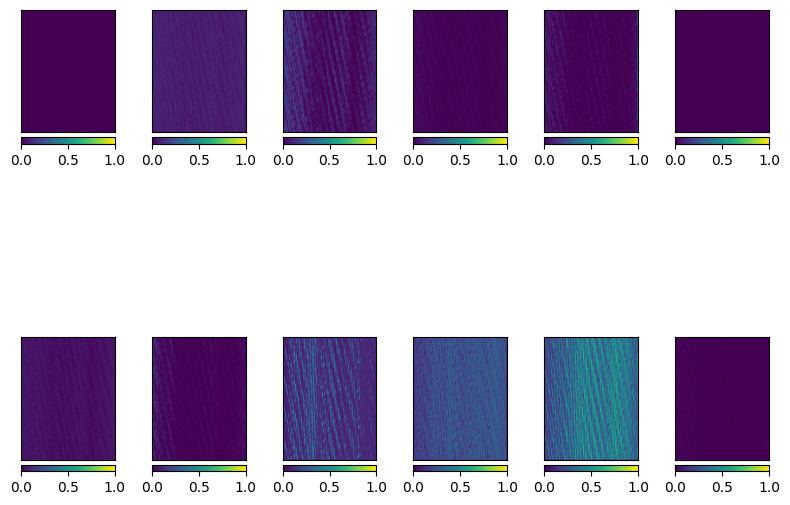

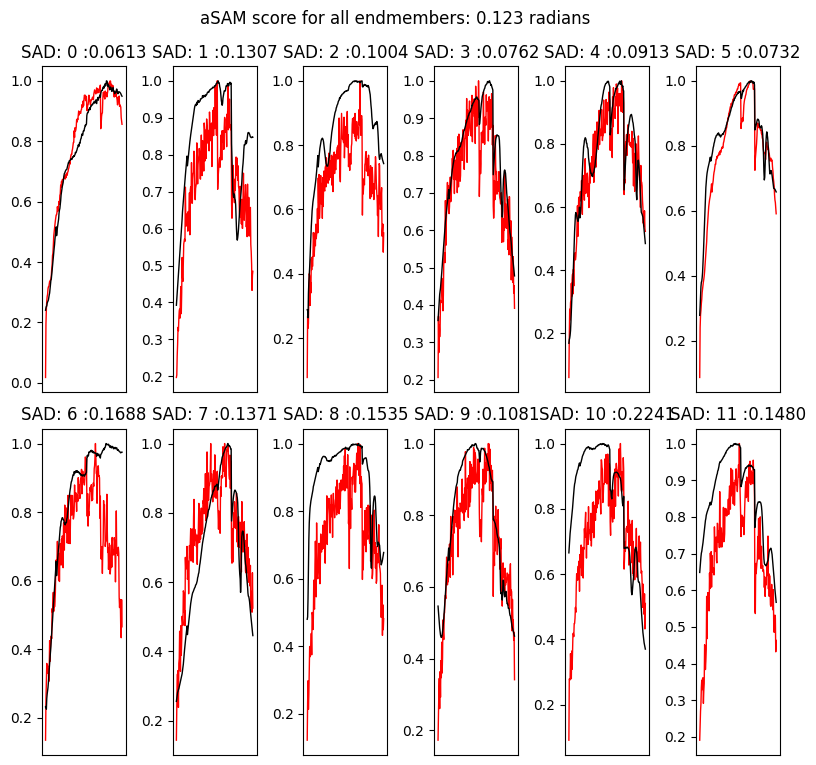

Run number: 2


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:05:35.889672: W tensorflow/c/c_api.cc:305] Operation '{name:'training_2/RMSprop/autoencoder_1/encoder_1/conv2d_2/kernel/rms/Assign' id:926 op device:{requested: '', assigned: ''} def:{{{node training_2/RMSprop/autoencoder_1/encoder_1/conv2d_2/kernel/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/RMSprop/autoencoder_1/encoder_1/conv2d_2/kernel/rms, training_2/RMSprop/autoencoder_1/encoder_1/conv2d_2/kernel/rms/Initializer/zeros)}}' was changed by setting attribute after it was run

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:08:38.244771: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_1/encoder_1/abundances/Softmax' id:701 op device:{requested: '', assigned: ''} def:{{{node autoencoder_1/encoder_1/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_1/encoder_1/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:08:38.337455: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match siz

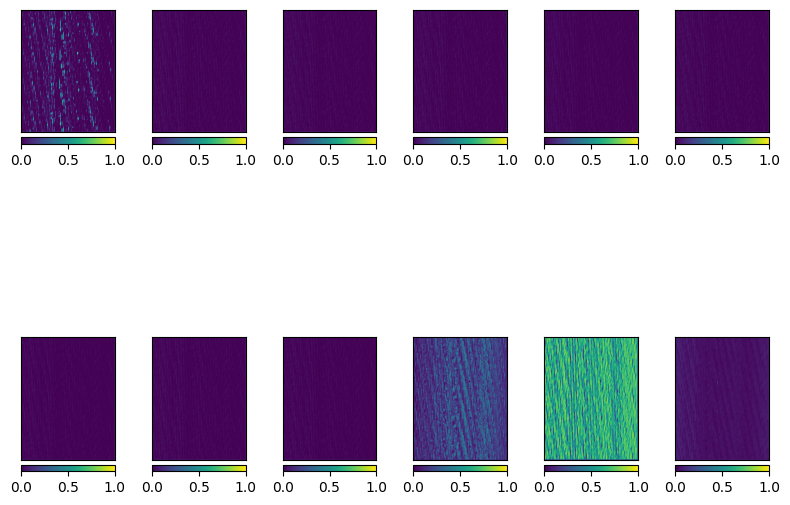

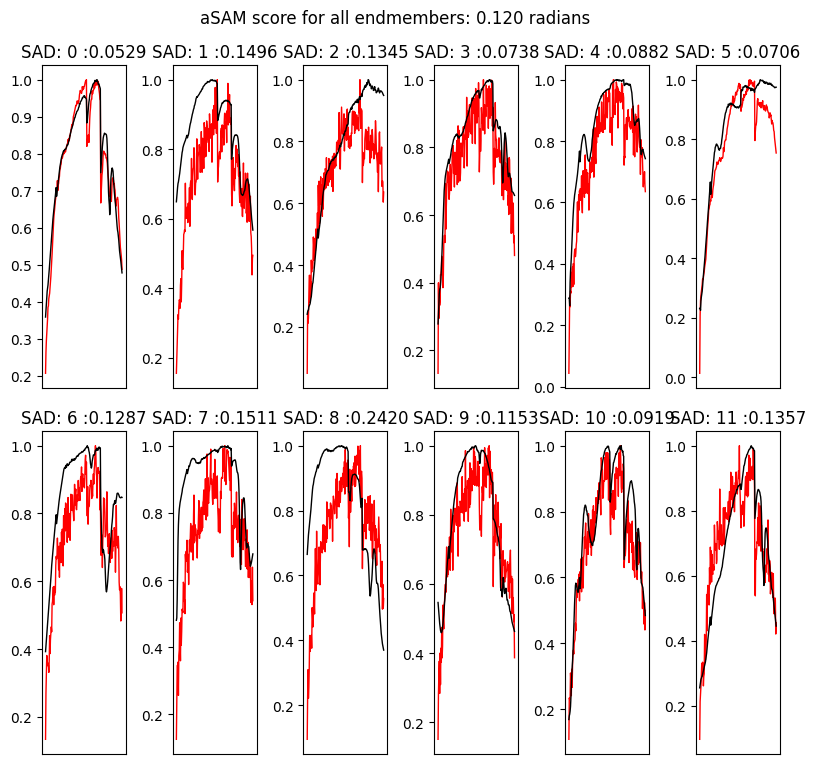

Run number: 3


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:08:41.613318: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_2/encoder_2/batch_normalization_4/moving_mean/Assign' id:1060 op device:{requested: '', assigned: ''} def:{{{node autoencoder_2/encoder_2/batch_normalization_4/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_2/encoder_2/batch_normalization_4/moving_mean, autoencoder_2/encoder_2/batch_normalization_4/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:11:33.454863: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_2/encoder_2/abundances/Softmax' id:1199 op device:{requested: '', assigned: ''} def:{{{node autoencoder_2/encoder_2/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_2/encoder_2/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:11:33.591334: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match si

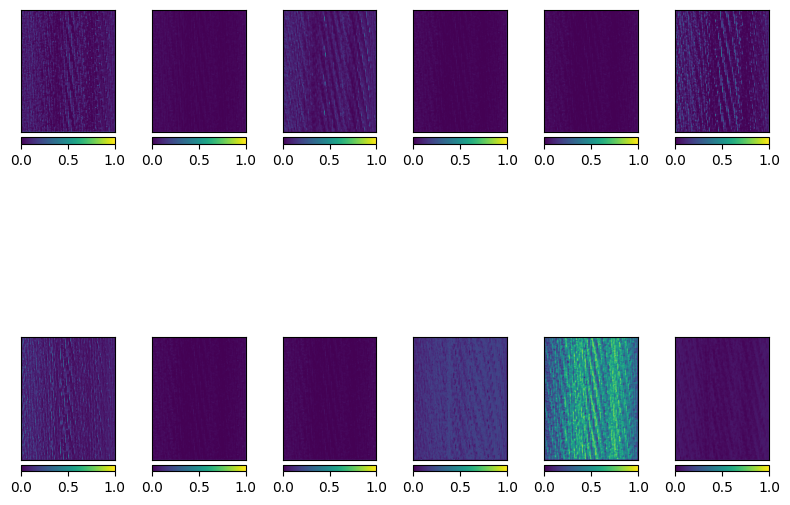

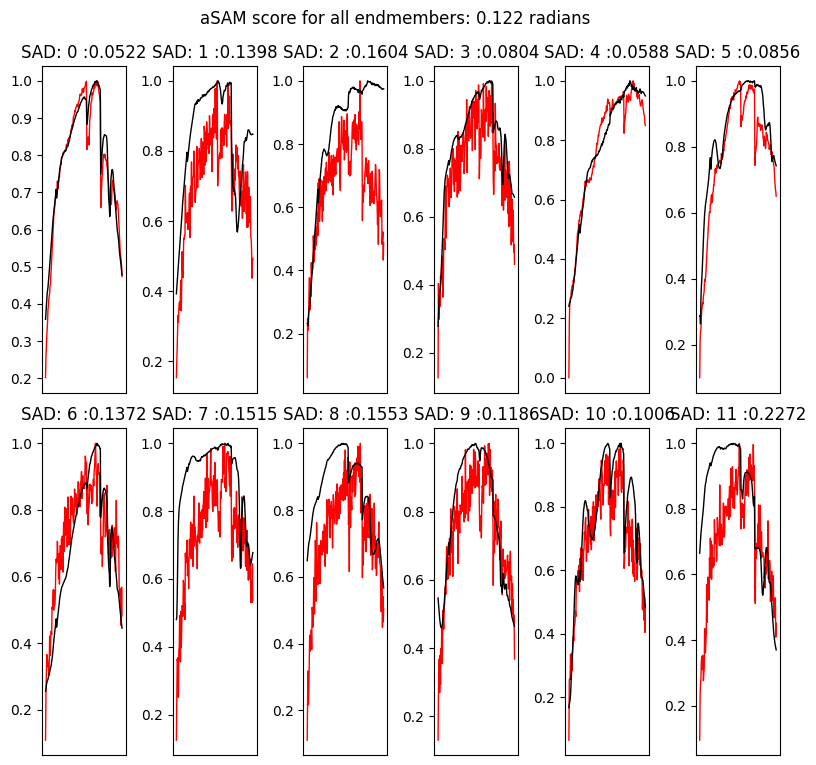

Run number: 4


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:11:36.588336: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_3/encoder_3/batch_normalization_6/moving_variance/Assign' id:1563 op device:{requested: '', assigned: ''} def:{{{node autoencoder_3/encoder_3/batch_normalization_6/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_3/encoder_3/batch_normalization_6/moving_variance, autoencoder_3/encoder_3/batch_normalization_6/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by 

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:14:47.280725: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_3/encoder_3/abundances/Softmax' id:1697 op device:{requested: '', assigned: ''} def:{{{node autoencoder_3/encoder_3/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_3/encoder_3/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:14:47.457445: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match si

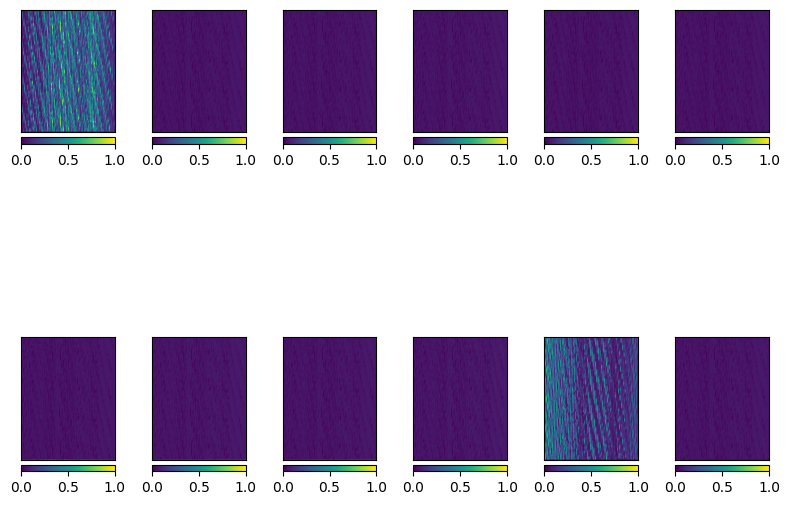

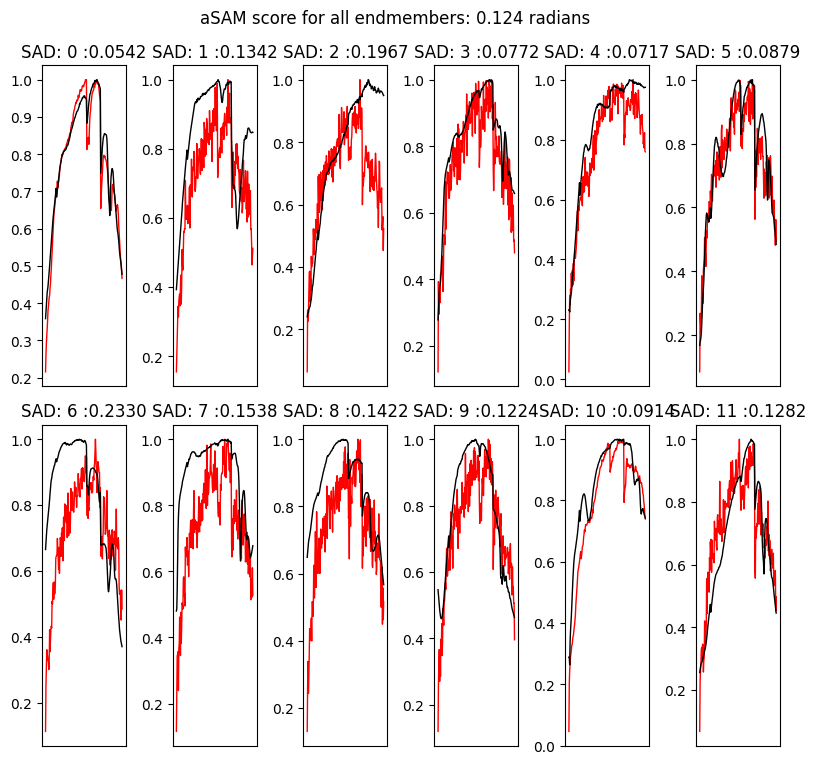

Run number: 5


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:14:50.797289: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_4/encoder_4/batch_normalization_9/moving_variance/Assign' id:2144 op device:{requested: '', assigned: ''} def:{{{node autoencoder_4/encoder_4/batch_normalization_9/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_4/encoder_4/batch_normalization_9/moving_variance, autoencoder_4/encoder_4/batch_normalization_9/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by 

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:17:51.760322: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_4/encoder_4/abundances/Softmax' id:2195 op device:{requested: '', assigned: ''} def:{{{node autoencoder_4/encoder_4/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_4/encoder_4/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:17:51.984461: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match si

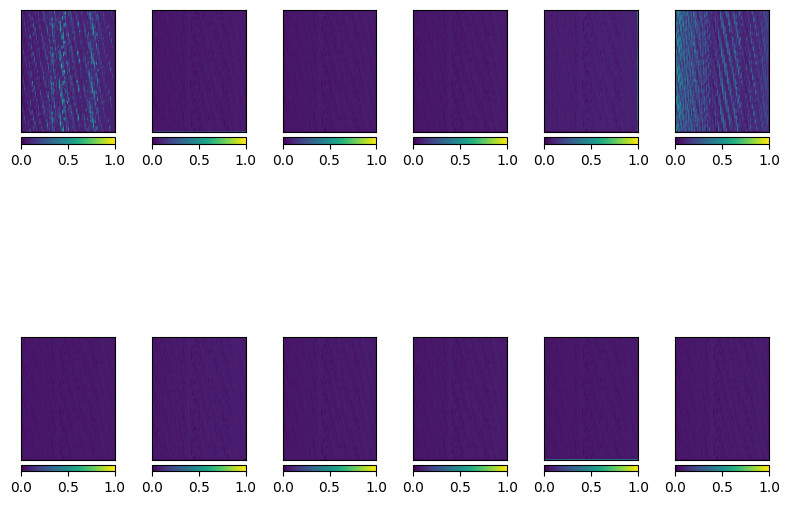

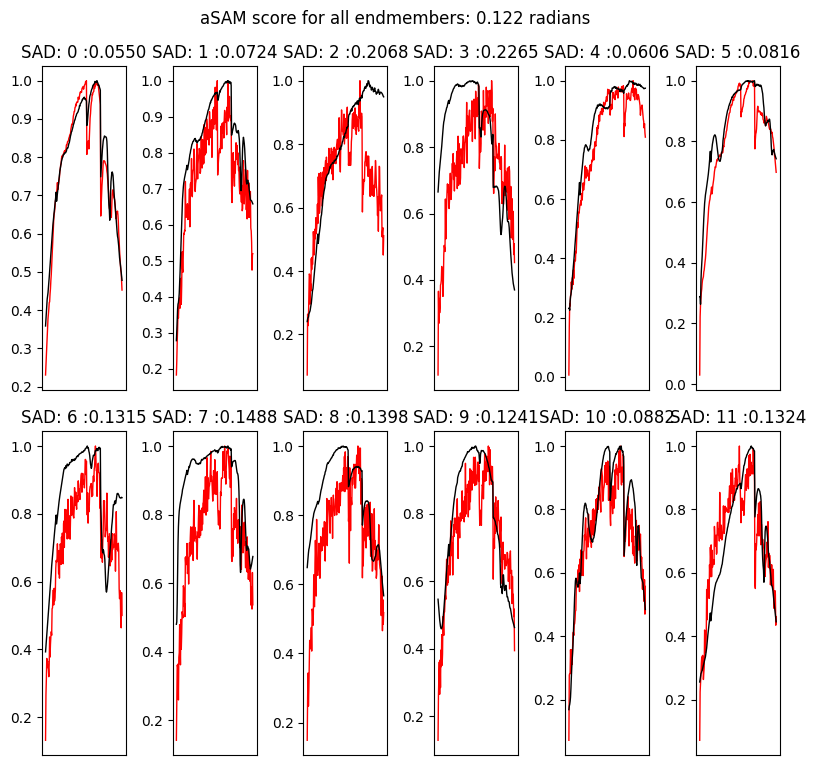

Run number: 6


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:17:55.436163: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_5/encoder_5/conv2d_11/kernel/Assign' id:2619 op device:{requested: '', assigned: ''} def:{{{node autoencoder_5/encoder_5/conv2d_11/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_5/encoder_5/conv2d_11/kernel, autoencoder_5/encoder_5/conv2d_11/kernel/Initializer/stateless_random_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:20:58.009329: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_5/encoder_5/abundances/Softmax' id:2693 op device:{requested: '', assigned: ''} def:{{{node autoencoder_5/encoder_5/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_5/encoder_5/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:20:58.285255: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match si

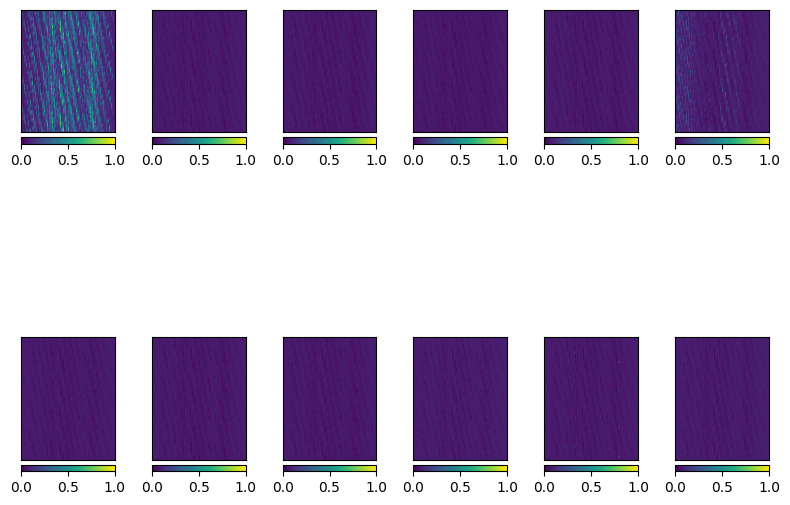

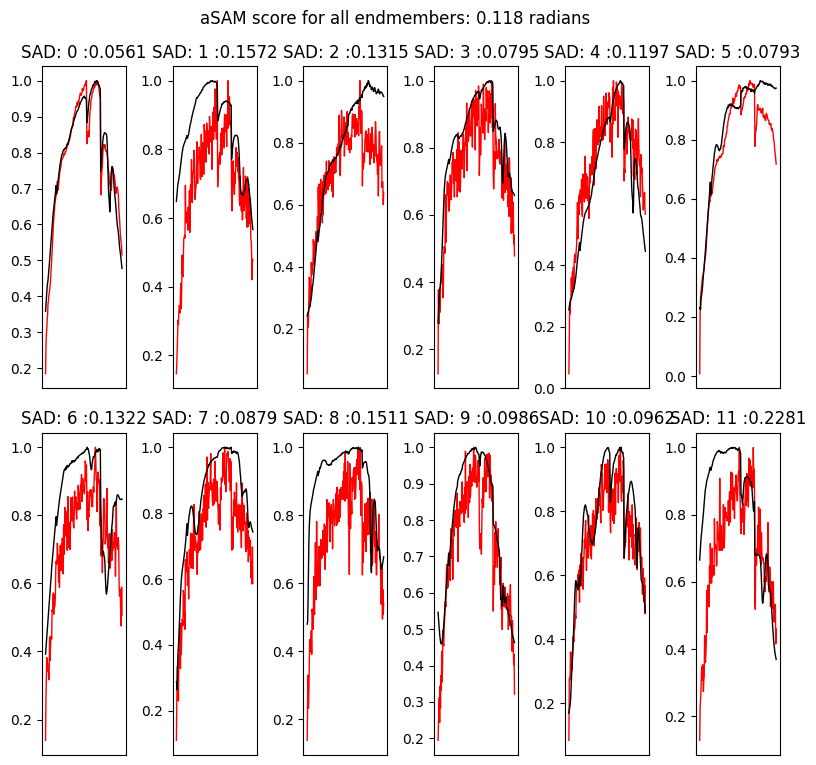

Run number: 7


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:21:01.447937: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_6/decoder_6/endmembers/kernel/Assign' id:3203 op device:{requested: '', assigned: ''} def:{{{node autoencoder_6/decoder_6/endmembers/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_6/decoder_6/endmembers/kernel, autoencoder_6/decoder_6/endmembers/kernel/Initializer/stateless_random_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigge

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:24:02.805703: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_6/encoder_6/abundances/Softmax' id:3191 op device:{requested: '', assigned: ''} def:{{{node autoencoder_6/encoder_6/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_6/encoder_6/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:24:03.125394: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match si

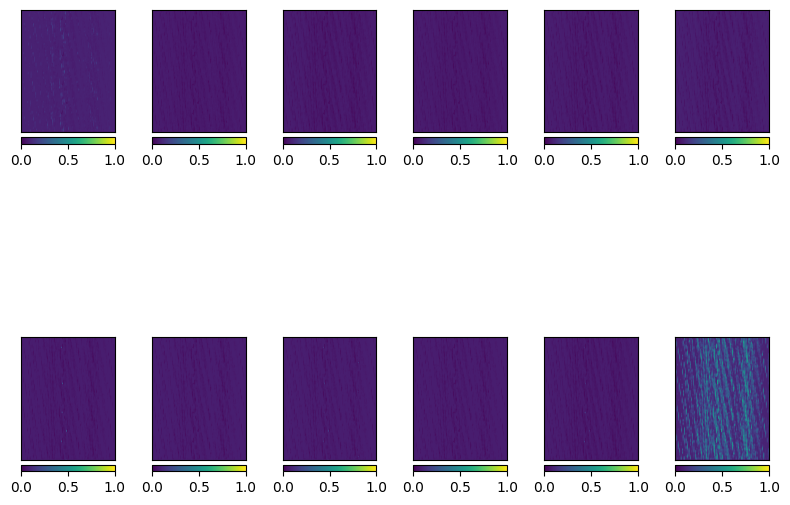

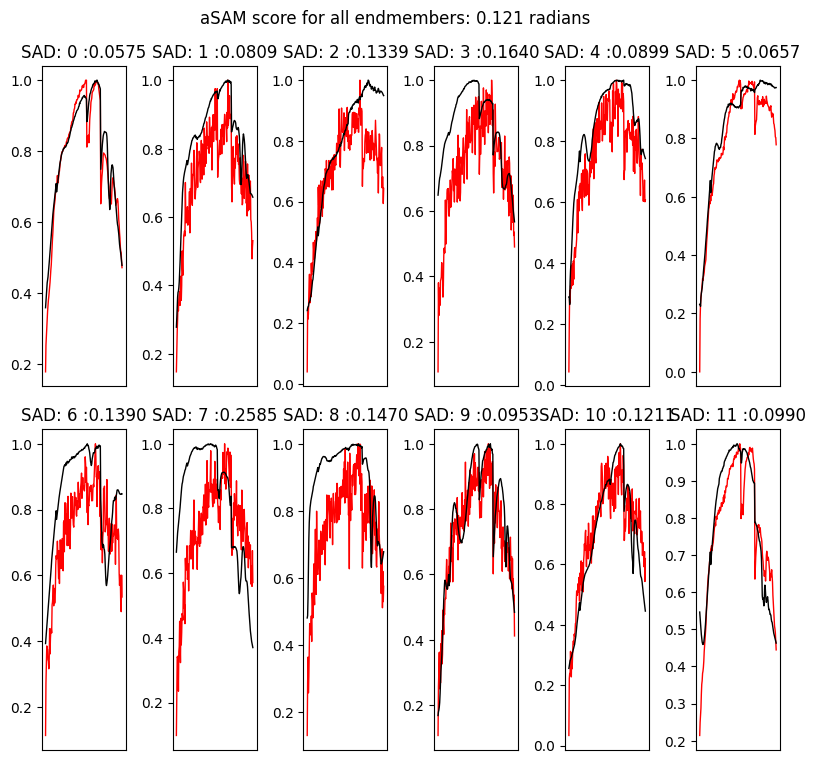

Run number: 8


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:24:06.730267: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_7/encoder_7/conv2d_15/kernel/Assign' id:3615 op device:{requested: '', assigned: ''} def:{{{node autoencoder_7/encoder_7/conv2d_15/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_7/encoder_7/conv2d_15/kernel, autoencoder_7/encoder_7/conv2d_15/kernel/Initializer/stateless_random_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:27:09.315985: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_7/encoder_7/abundances/Softmax' id:3689 op device:{requested: '', assigned: ''} def:{{{node autoencoder_7/encoder_7/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_7/encoder_7/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:27:09.685664: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match si

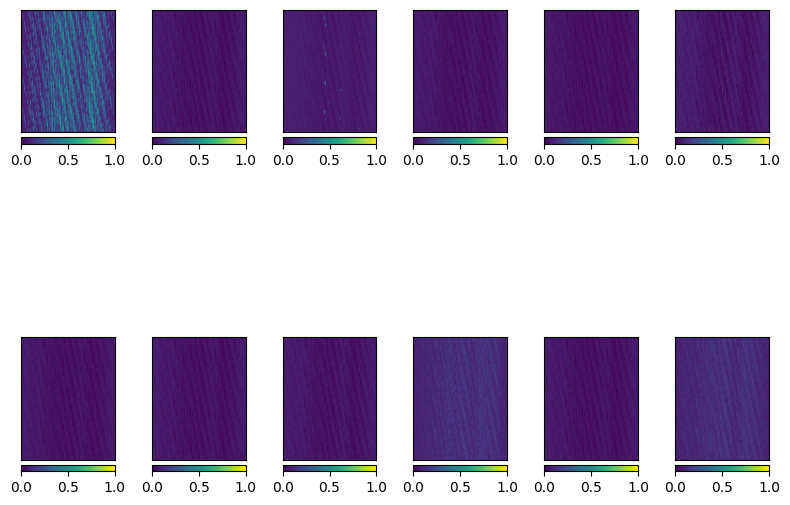

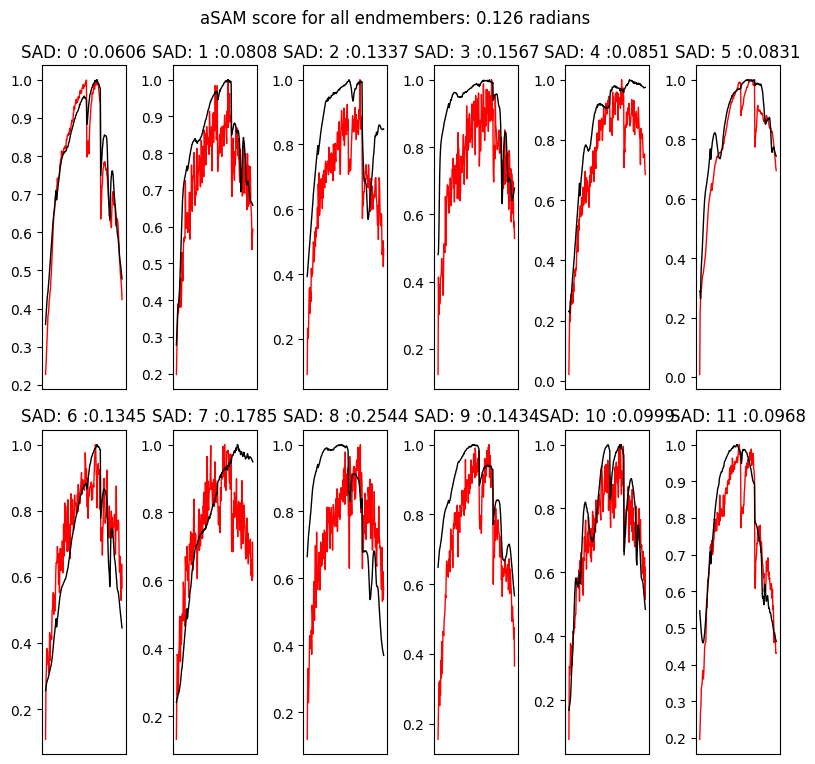

Run number: 9


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:27:13.327309: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_8/encoder_8/batch_normalization_17/moving_mean/Assign' id:4131 op device:{requested: '', assigned: ''} def:{{{node autoencoder_8/encoder_8/batch_normalization_17/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_8/encoder_8/batch_normalization_17/moving_mean, autoencoder_8/encoder_8/batch_normalization_17/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. 

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:30:20.807733: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_8/encoder_8/abundances/Softmax' id:4187 op device:{requested: '', assigned: ''} def:{{{node autoencoder_8/encoder_8/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_8/encoder_8/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:30:21.232190: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match si

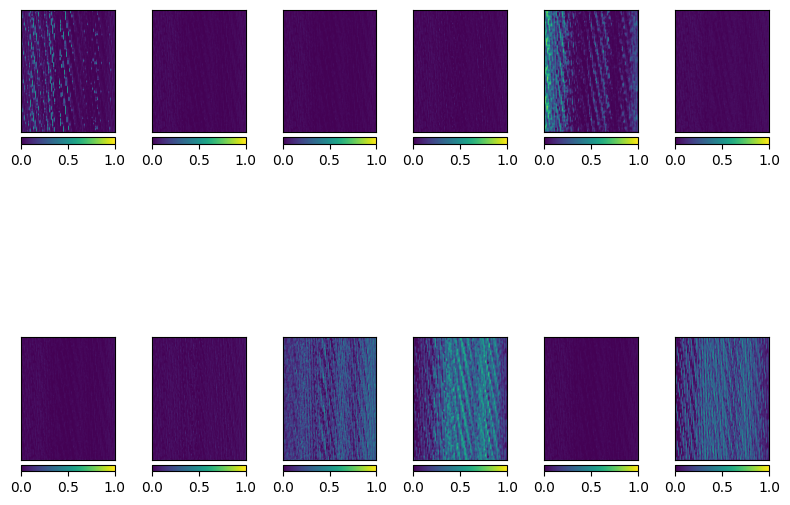

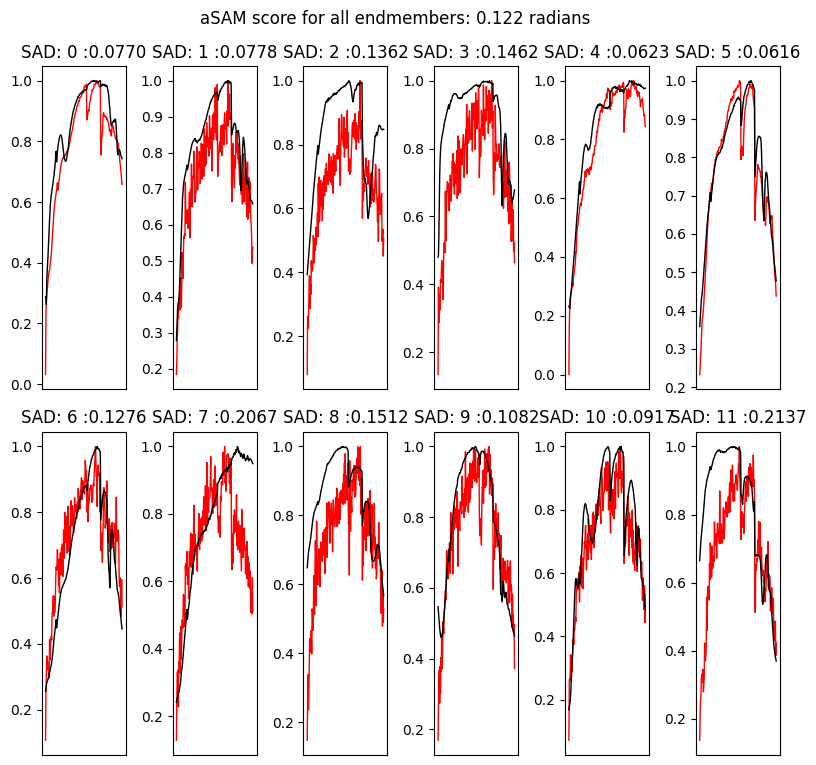

Run number: 10


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:30:24.617059: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_9/encoder_9/batch_normalization_19/beta/Assign' id:4624 op device:{requested: '', assigned: ''} def:{{{node autoencoder_9/encoder_9/batch_normalization_19/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_9/encoder_9/batch_normalization_19/beta, autoencoder_9/encoder_9/batch_normalization_19/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no e

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:33:28.320957: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_9/encoder_9/abundances/Softmax' id:4685 op device:{requested: '', assigned: ''} def:{{{node autoencoder_9/encoder_9/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_9/encoder_9/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:33:28.807056: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match si

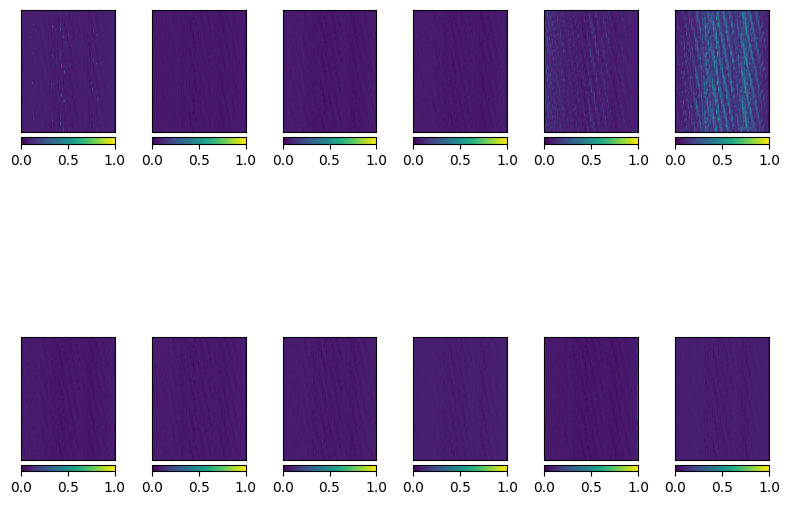

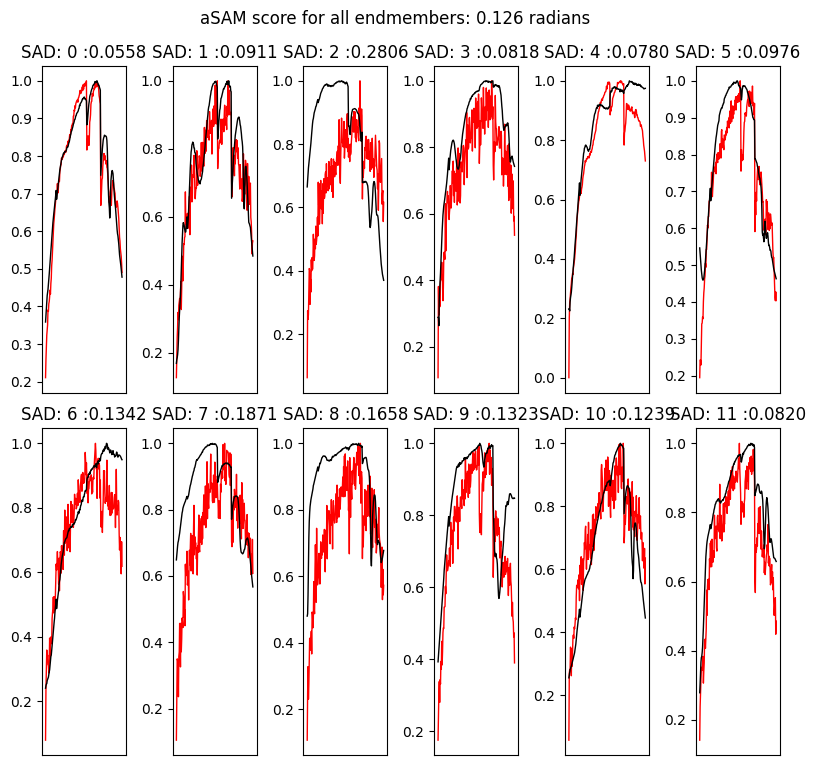

Run number: 11


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:33:32.595983: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_10/encoder_10/batch_normalization_21/gamma/Assign' id:5117 op device:{requested: '', assigned: ''} def:{{{node autoencoder_10/encoder_10/batch_normalization_21/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_10/encoder_10/batch_normalization_21/gamma, autoencoder_10/encoder_10/batch_normalization_21/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation wil

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:36:37.198172: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_10/encoder_10/abundances/Softmax' id:5183 op device:{requested: '', assigned: ''} def:{{{node autoencoder_10/encoder_10/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_10/encoder_10/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:36:37.727559: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not ma

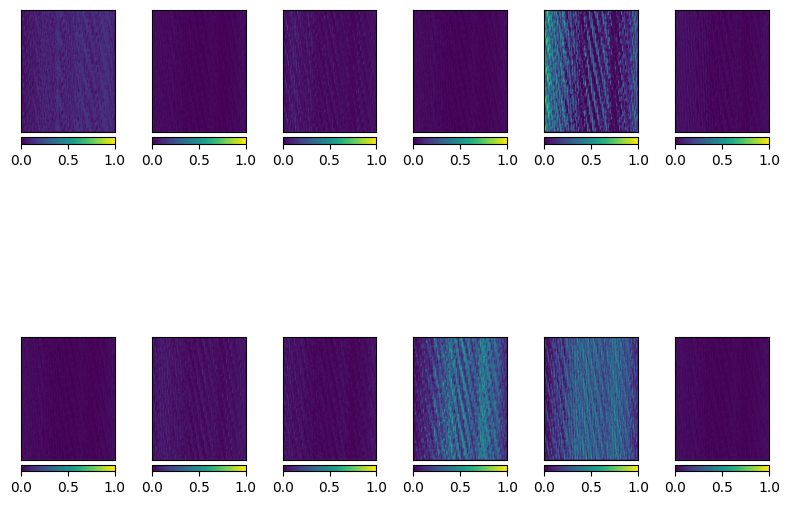

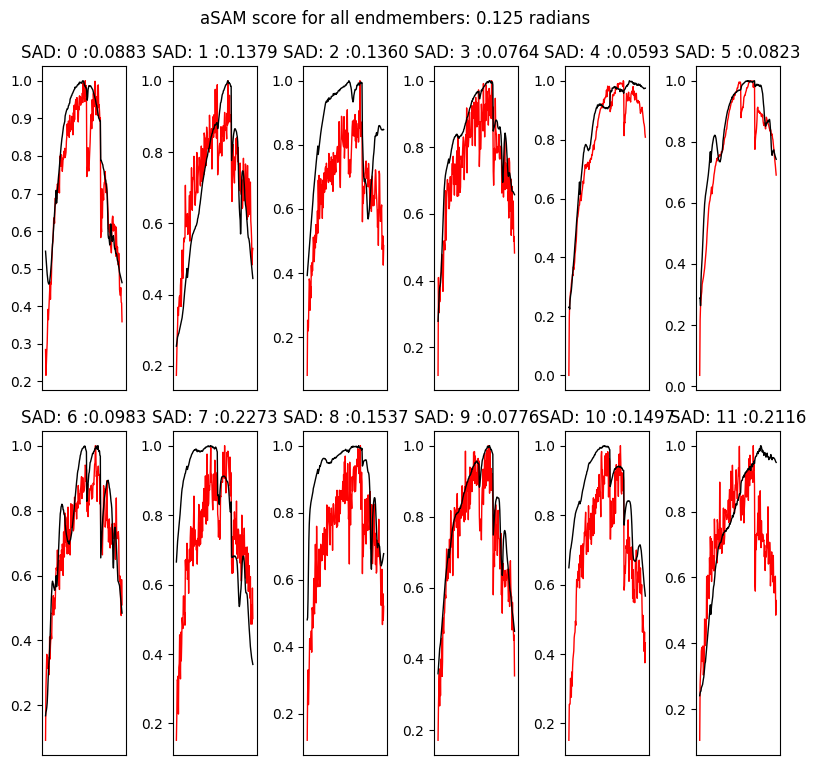

Run number: 12


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:36:41.297870: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_11/encoder_11/batch_normalization_23/moving_mean/Assign' id:5625 op device:{requested: '', assigned: ''} def:{{{node autoencoder_11/encoder_11/batch_normalization_23/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_11/encoder_11/batch_normalization_23/moving_mean, autoencoder_11/encoder_11/batch_normalization_23/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a s

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:39:35.478380: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_11/encoder_11/abundances/Softmax' id:5681 op device:{requested: '', assigned: ''} def:{{{node autoencoder_11/encoder_11/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_11/encoder_11/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:39:36.067493: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not ma

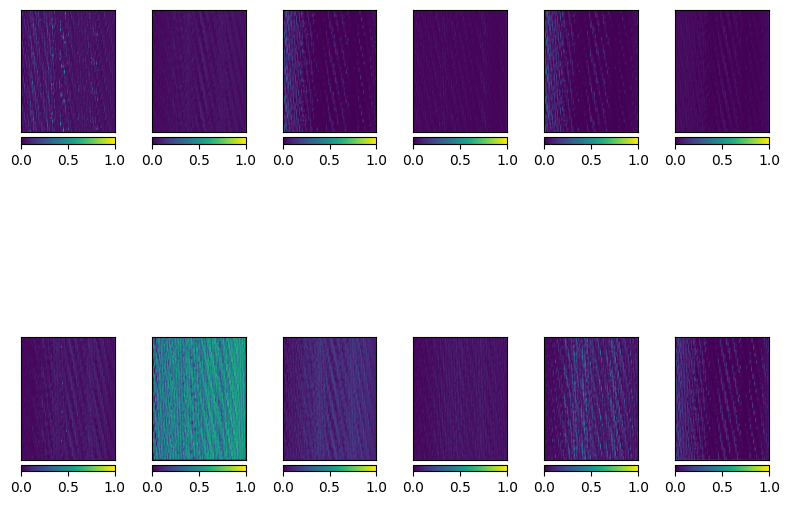

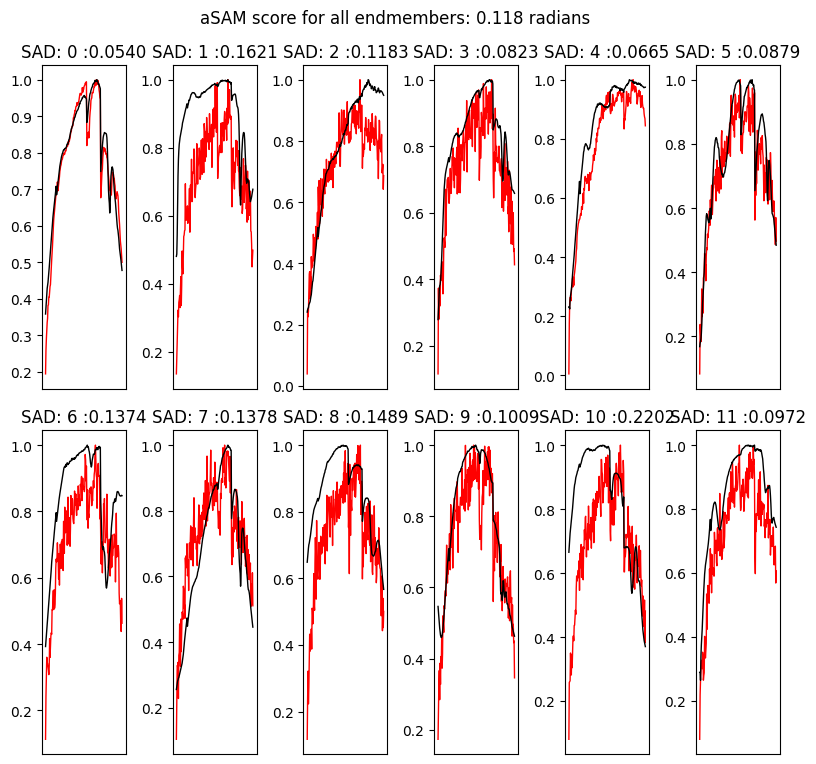

Run number: 13


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:39:40.100607: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_12/encoder_12/batch_normalization_25/beta/Assign' id:6118 op device:{requested: '', assigned: ''} def:{{{node autoencoder_12/encoder_12/batch_normalization_25/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_12/encoder_12/batch_normalization_25/beta, autoencoder_12/encoder_12/batch_normalization_25/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will h

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:42:44.099537: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_12/encoder_12/abundances/Softmax' id:6179 op device:{requested: '', assigned: ''} def:{{{node autoencoder_12/encoder_12/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_12/encoder_12/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:42:44.722392: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not ma

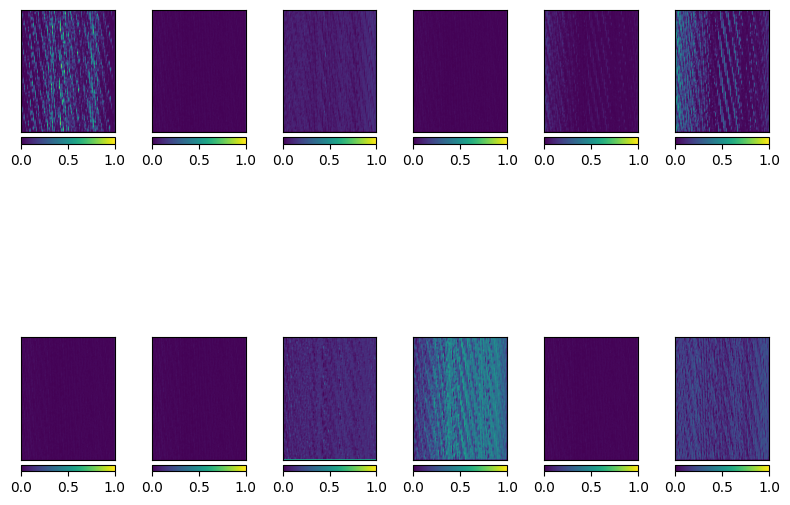

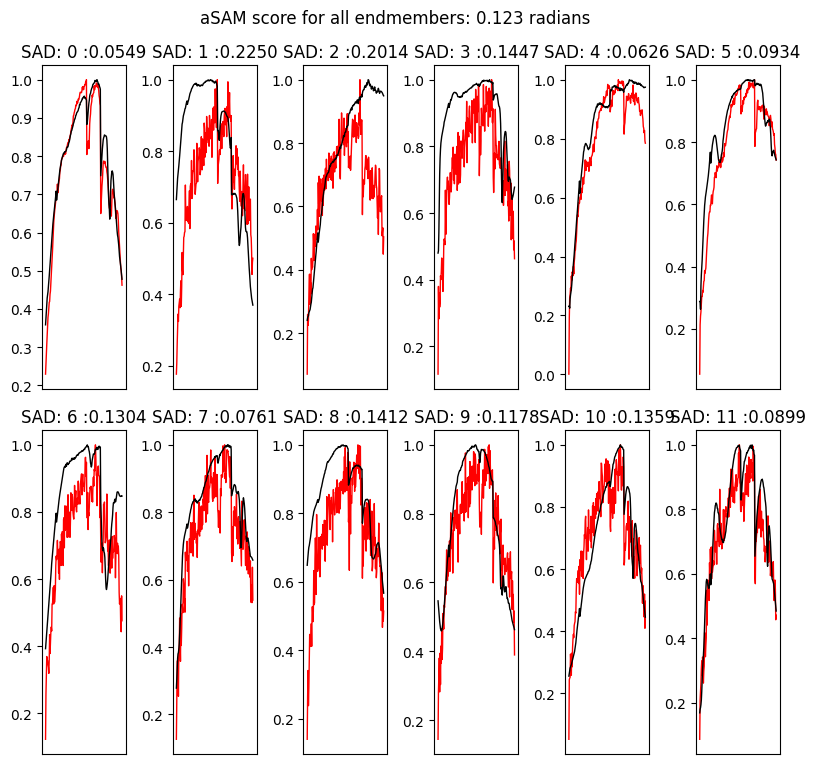

Run number: 14


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:42:48.721838: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_13/encoder_13/conv2d_26/kernel/Assign' id:6520 op device:{requested: '', assigned: ''} def:{{{node autoencoder_13/encoder_13/conv2d_26/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_13/encoder_13/conv2d_26/kernel, autoencoder_13/encoder_13/conv2d_26/kernel/Initializer/stateless_random_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will tr

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:45:53.022539: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_13/encoder_13/abundances/Softmax' id:6677 op device:{requested: '', assigned: ''} def:{{{node autoencoder_13/encoder_13/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_13/encoder_13/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:45:53.697581: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not ma

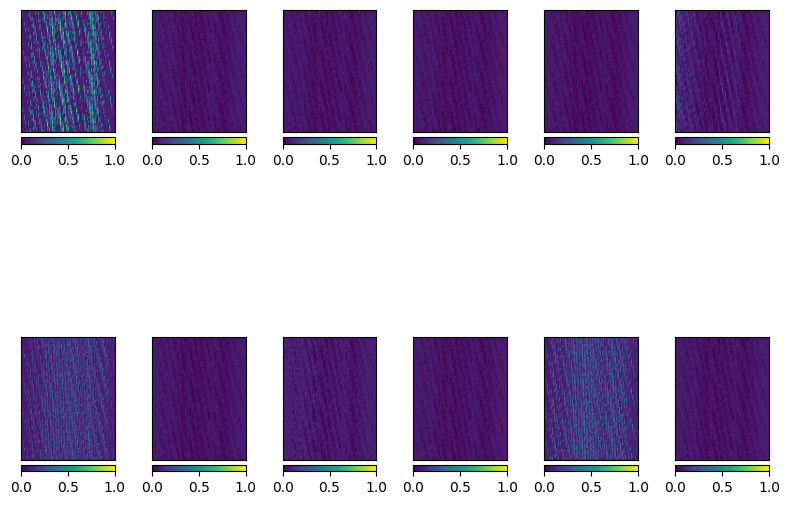

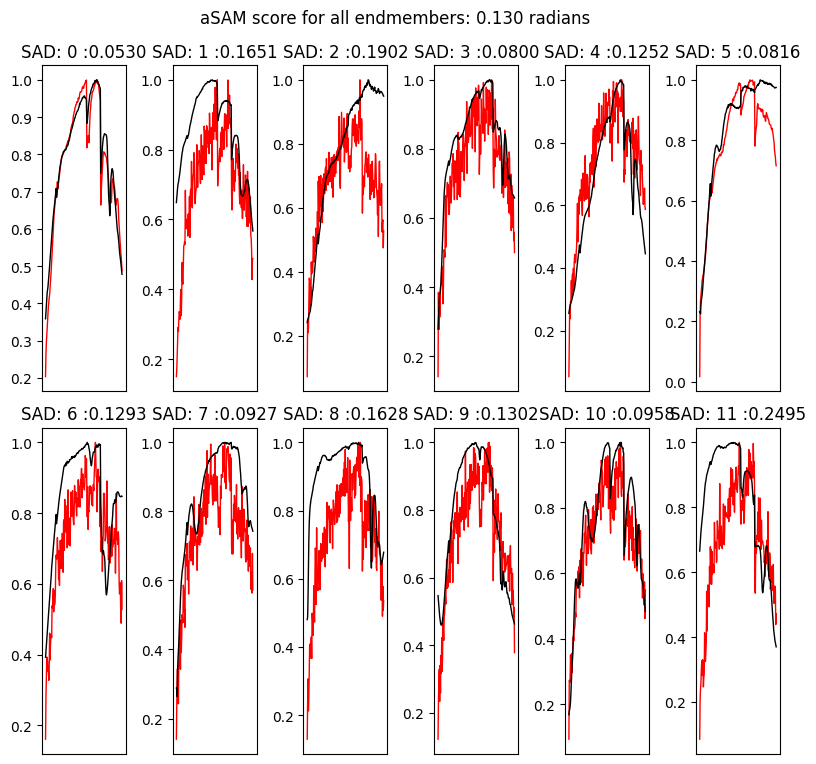

Run number: 15


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:45:57.401407: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_14/encoder_14/batch_normalization_28/beta/Assign' id:7031 op device:{requested: '', assigned: ''} def:{{{node autoencoder_14/encoder_14/batch_normalization_28/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_14/encoder_14/batch_normalization_28/beta, autoencoder_14/encoder_14/batch_normalization_28/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will h

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:49:03.445853: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_14/encoder_14/abundances/Softmax' id:7175 op device:{requested: '', assigned: ''} def:{{{node autoencoder_14/encoder_14/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_14/encoder_14/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:49:04.202365: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not ma

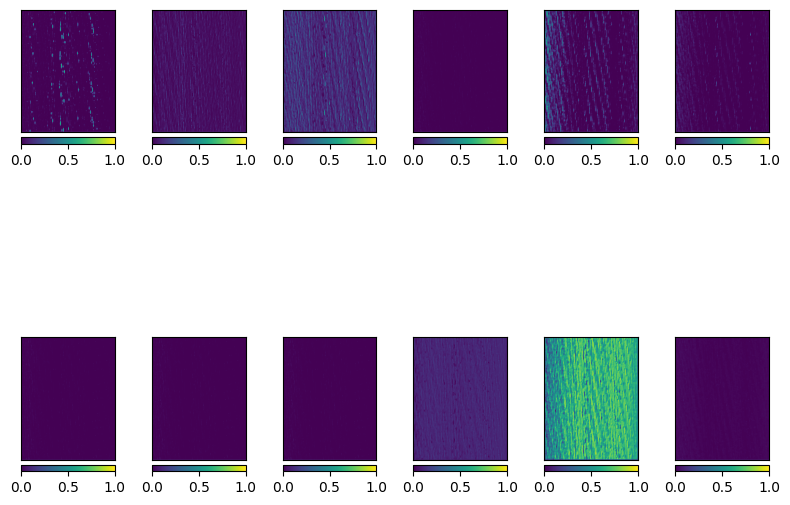

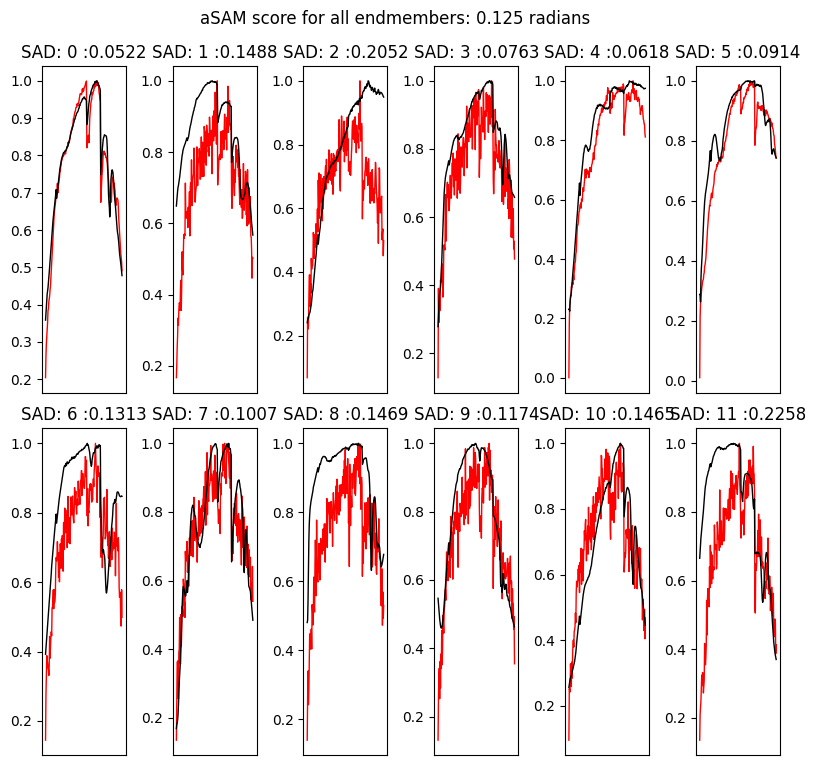

Run number: 16


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:49:08.366011: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_15/encoder_15/batch_normalization_30/moving_mean/Assign' id:7534 op device:{requested: '', assigned: ''} def:{{{node autoencoder_15/encoder_15/batch_normalization_30/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_15/encoder_15/batch_normalization_30/moving_mean, autoencoder_15/encoder_15/batch_normalization_30/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a s

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:52:22.785116: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_15/encoder_15/abundances/Softmax' id:7673 op device:{requested: '', assigned: ''} def:{{{node autoencoder_15/encoder_15/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_15/encoder_15/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:52:23.571211: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not ma

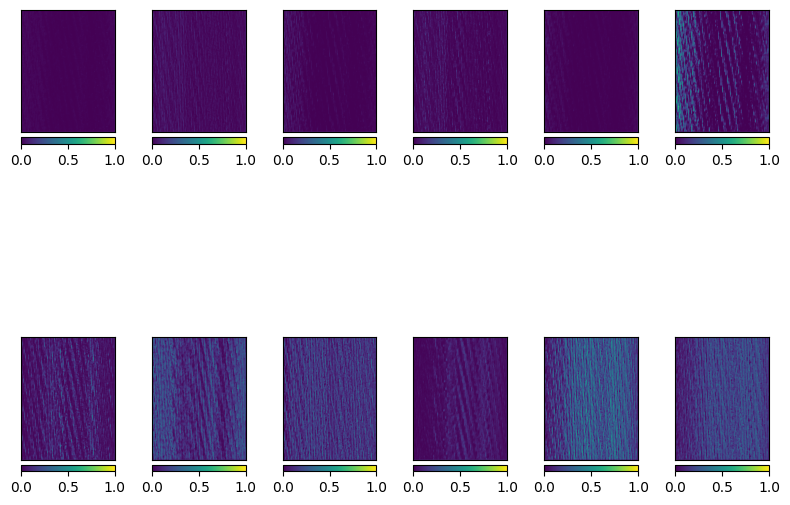

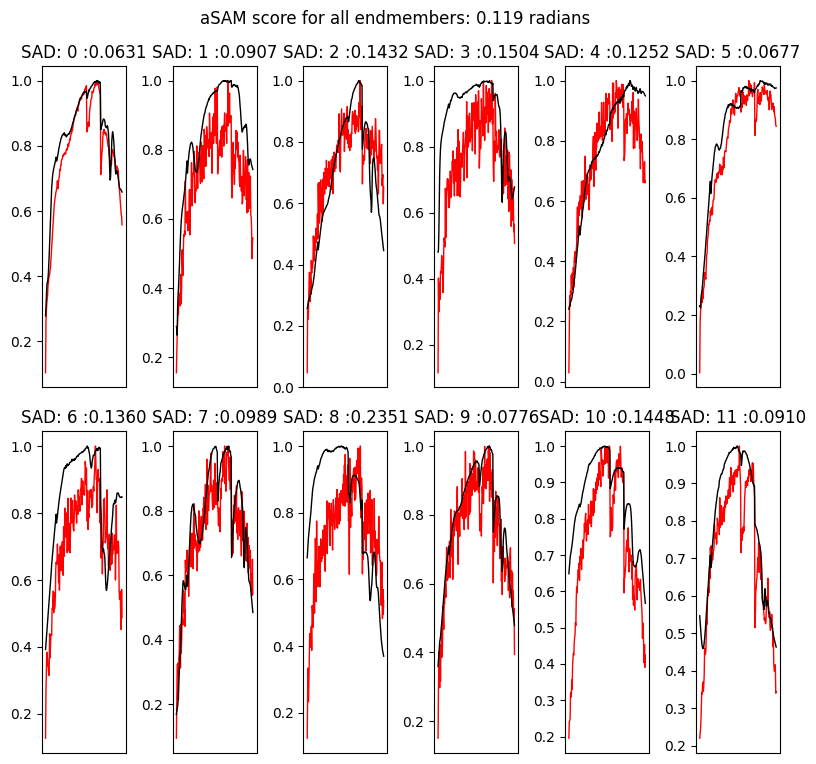

Run number: 17


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:52:27.371335: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_16/encoder_16/batch_normalization_33/moving_mean/Assign' id:8115 op device:{requested: '', assigned: ''} def:{{{node autoencoder_16/encoder_16/batch_normalization_33/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_16/encoder_16/batch_normalization_33/moving_mean, autoencoder_16/encoder_16/batch_normalization_33/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a s

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:55:41.974772: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_16/encoder_16/abundances/Softmax' id:8171 op device:{requested: '', assigned: ''} def:{{{node autoencoder_16/encoder_16/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_16/encoder_16/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:55:42.818670: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not ma

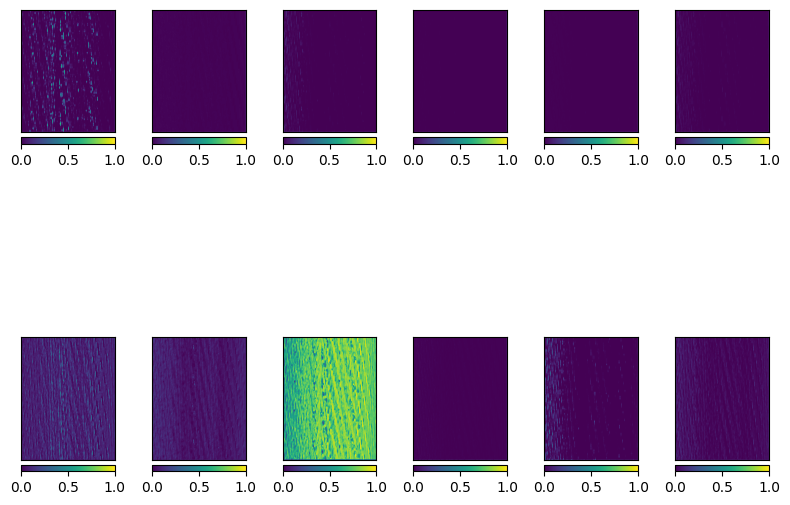

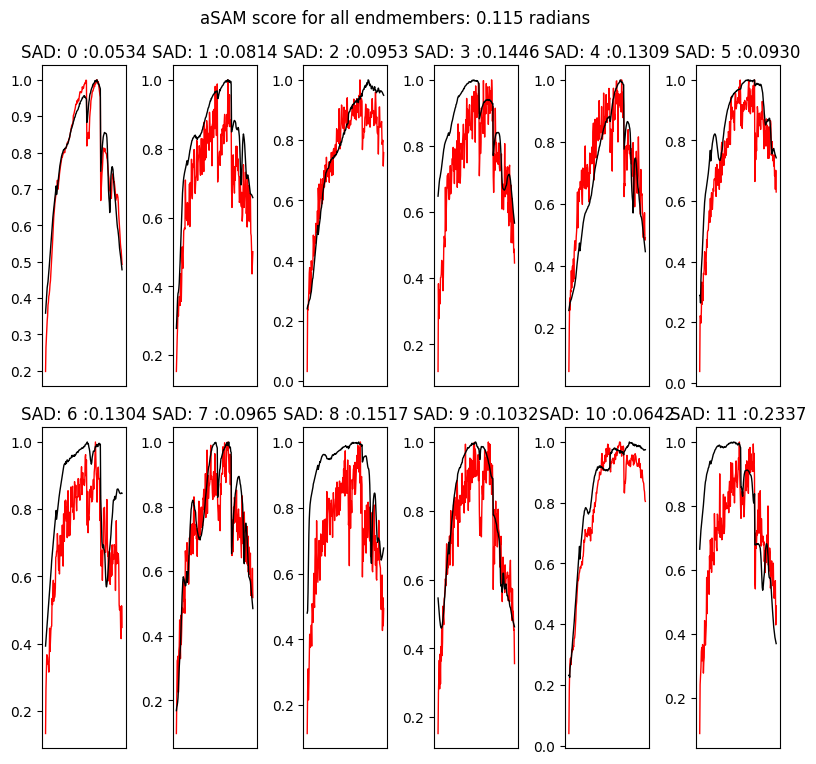

Run number: 18


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:55:47.103365: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_17/encoder_17/batch_normalization_35/beta/Assign' id:8608 op device:{requested: '', assigned: ''} def:{{{node autoencoder_17/encoder_17/batch_normalization_35/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_17/encoder_17/batch_normalization_35/beta, autoencoder_17/encoder_17/batch_normalization_35/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will h

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 16:59:02.439424: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_17/encoder_17/abundances/Softmax' id:8669 op device:{requested: '', assigned: ''} def:{{{node autoencoder_17/encoder_17/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_17/encoder_17/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 16:59:03.330005: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not ma

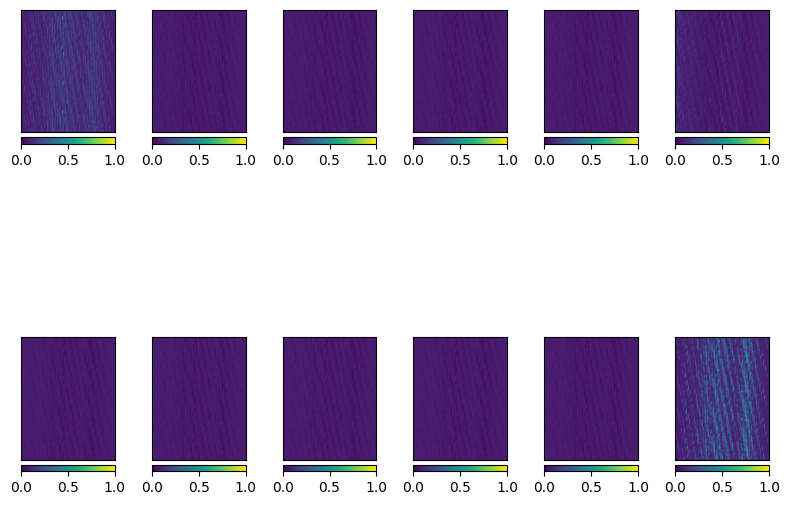

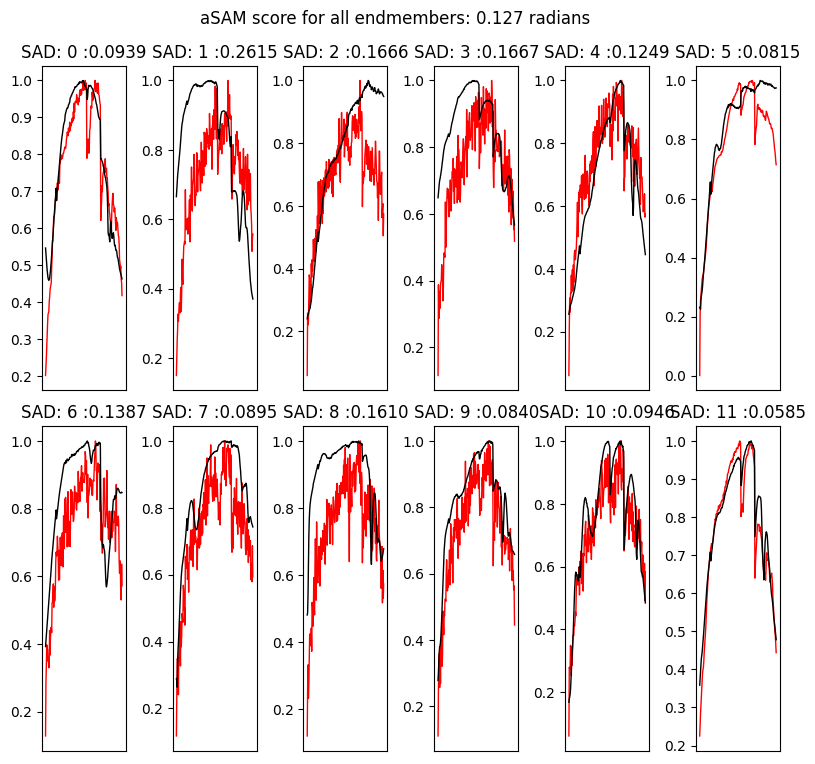

Run number: 19


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 16:59:07.303108: W tensorflow/c/c_api.cc:305] Operation '{name:'training_36/RMSprop/autoencoder_18/decoder_18/endmembers/kernel/rms/Assign' id:9404 op device:{requested: '', assigned: ''} def:{{{node training_36/RMSprop/autoencoder_18/decoder_18/endmembers/kernel/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_36/RMSprop/autoencoder_18/decoder_18/endmembers/kernel/rms, training_36/RMSprop/autoencoder_18/decoder_18/endmembers/kernel/rms/Initializer/zeros)}}' was changed by setting attri

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 17:02:21.493475: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_18/encoder_18/abundances/Softmax' id:9167 op device:{requested: '', assigned: ''} def:{{{node autoencoder_18/encoder_18/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_18/encoder_18/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 17:02:22.448778: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not ma

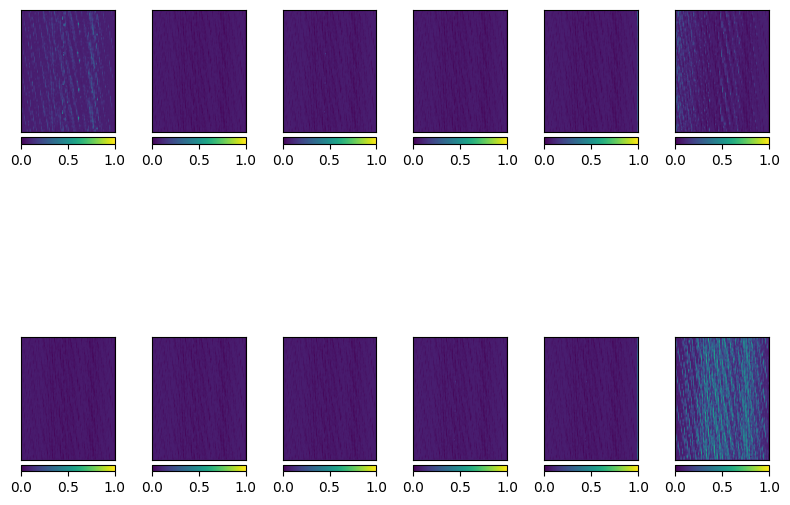

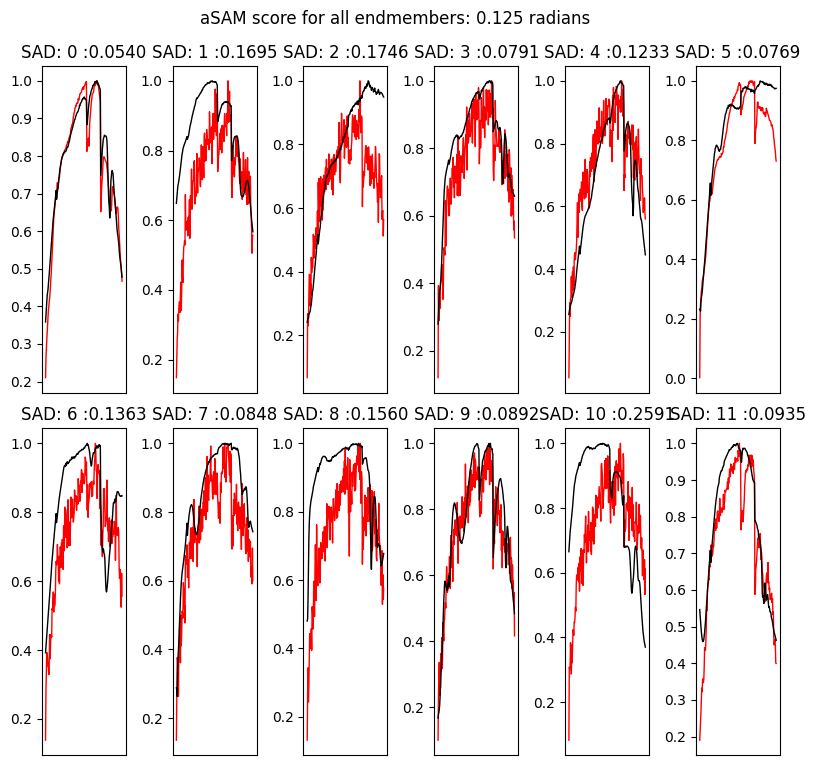

Run number: 20


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 17:02:26.914148: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_19/encoder_19/batch_normalization_39/moving_variance/Assign' id:9614 op device:{requested: '', assigned: ''} def:{{{node autoencoder_19/encoder_19/batch_normalization_39/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_19/encoder_19/batch_normalization_39/moving_variance, autoencoder_19/encoder_19/batch_normalization_39/moving_variance/Initializer/ones)}}' was changed by setting attribute after it

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 17:05:30.694072: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_19/encoder_19/abundances/Softmax' id:9665 op device:{requested: '', assigned: ''} def:{{{node autoencoder_19/encoder_19/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_19/encoder_19/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 17:05:31.717147: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not ma

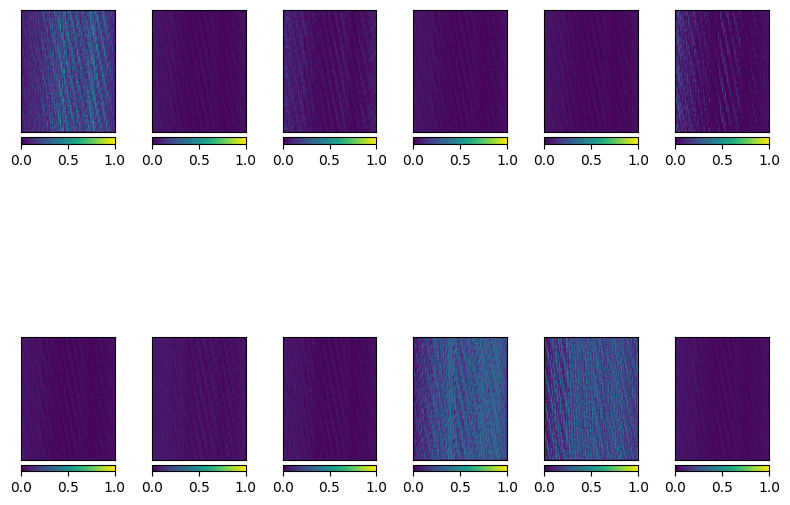

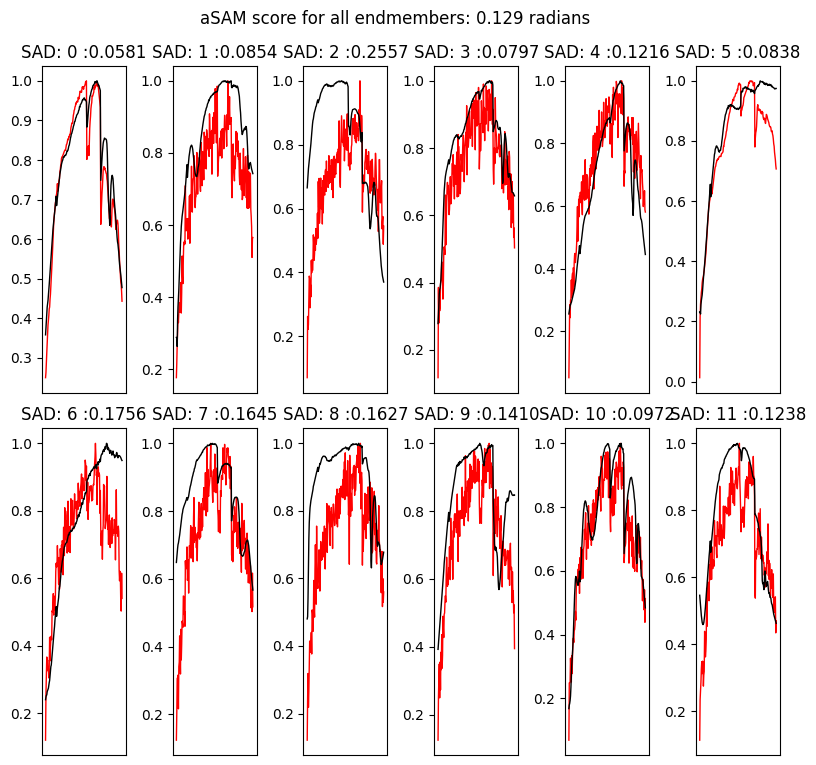

Run number: 21


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 17:05:35.752489: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_20/encoder_20/batch_normalization_40/gamma/Assign' id:10014 op device:{requested: '', assigned: ''} def:{{{node autoencoder_20/encoder_20/batch_normalization_40/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_20/encoder_20/batch_normalization_40/gamma, autoencoder_20/encoder_20/batch_normalization_40/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation wi

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 17:08:31.661938: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_20/encoder_20/abundances/Softmax' id:10163 op device:{requested: '', assigned: ''} def:{{{node autoencoder_20/encoder_20/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_20/encoder_20/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 17:08:32.722559: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not m

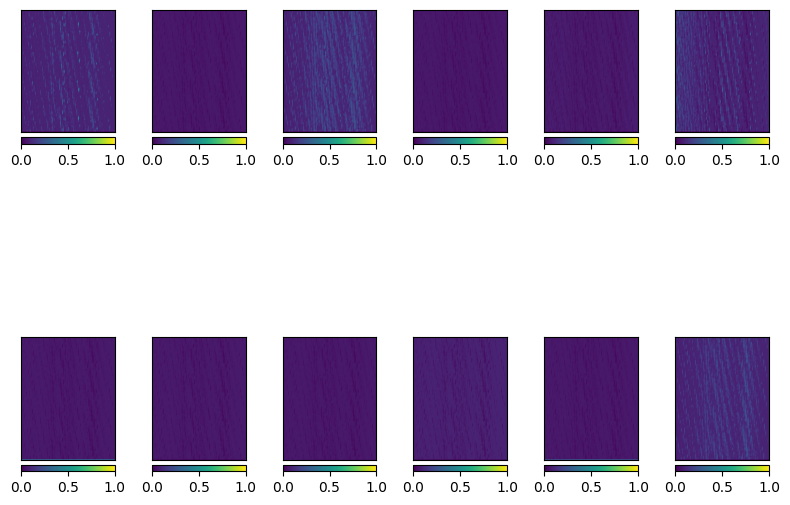

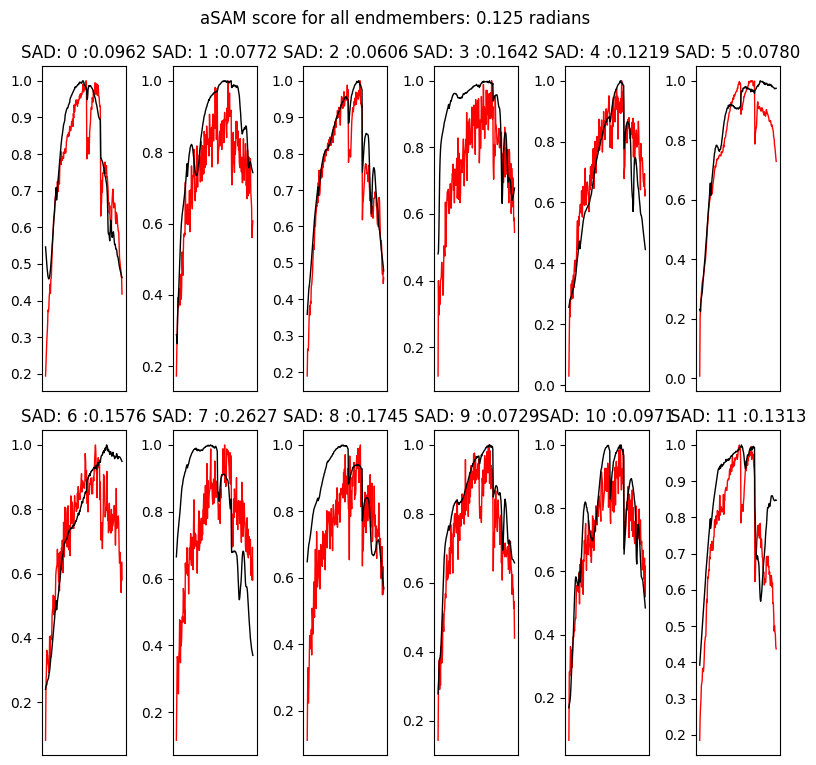

Run number: 22


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 17:08:37.336884: W tensorflow/c/c_api.cc:305] Operation '{name:'training_42/RMSprop/autoencoder_21/encoder_21/conv2d_43/kernel/rms/Assign' id:10891 op device:{requested: '', assigned: ''} def:{{{node training_42/RMSprop/autoencoder_21/encoder_21/conv2d_43/kernel/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_42/RMSprop/autoencoder_21/encoder_21/conv2d_43/kernel/rms, training_42/RMSprop/autoencoder_21/encoder_21/conv2d_43/kernel/rms/Initializer/zeros)}}' was changed by setting attribut

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 17:11:41.727418: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_21/encoder_21/abundances/Softmax' id:10661 op device:{requested: '', assigned: ''} def:{{{node autoencoder_21/encoder_21/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_21/encoder_21/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 17:11:42.834704: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not m

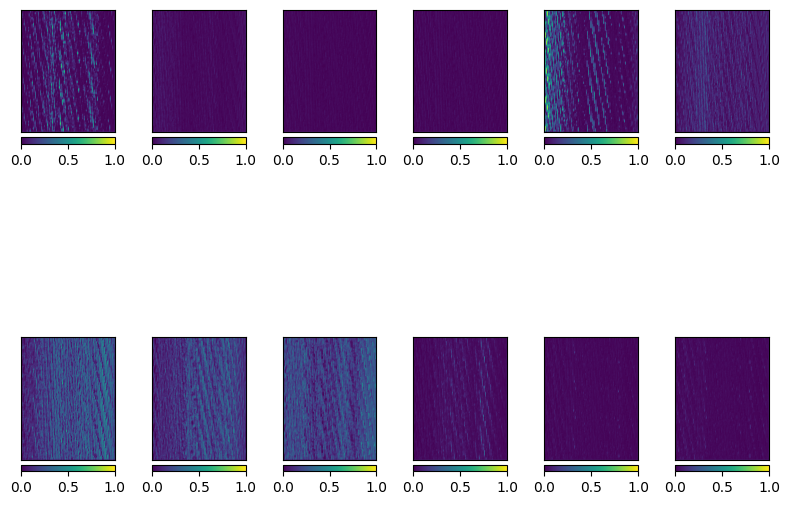

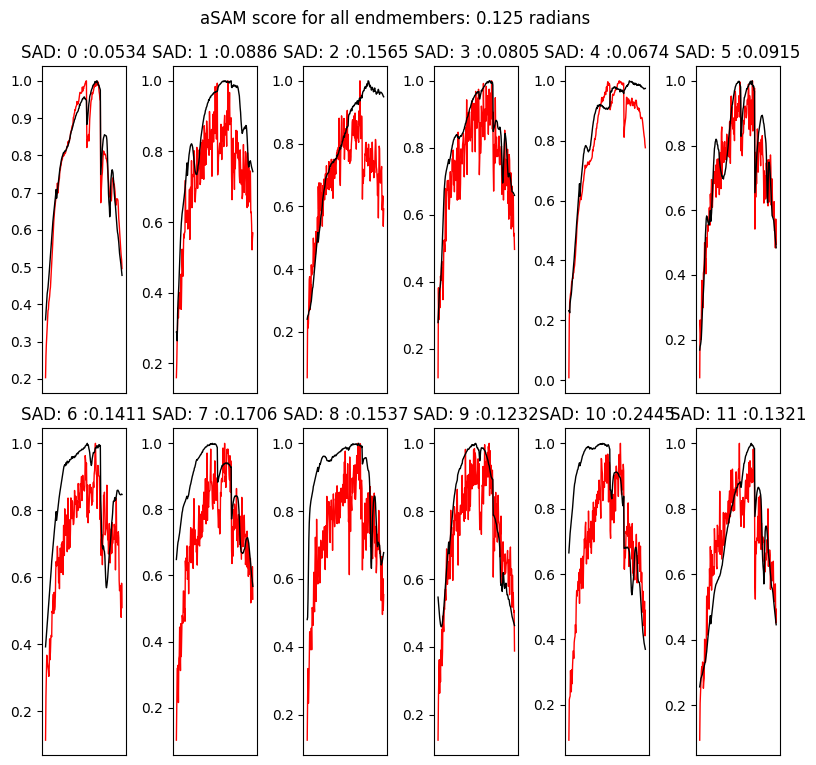

Run number: 23


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 17:11:46.979310: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_22/encoder_22/conv2d_45/kernel/Assign' id:11085 op device:{requested: '', assigned: ''} def:{{{node autoencoder_22/encoder_22/conv2d_45/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_22/encoder_22/conv2d_45/kernel, autoencoder_22/encoder_22/conv2d_45/kernel/Initializer/stateless_random_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will t

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 17:14:51.232897: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_22/encoder_22/abundances/Softmax' id:11159 op device:{requested: '', assigned: ''} def:{{{node autoencoder_22/encoder_22/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_22/encoder_22/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 17:14:52.383075: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not m

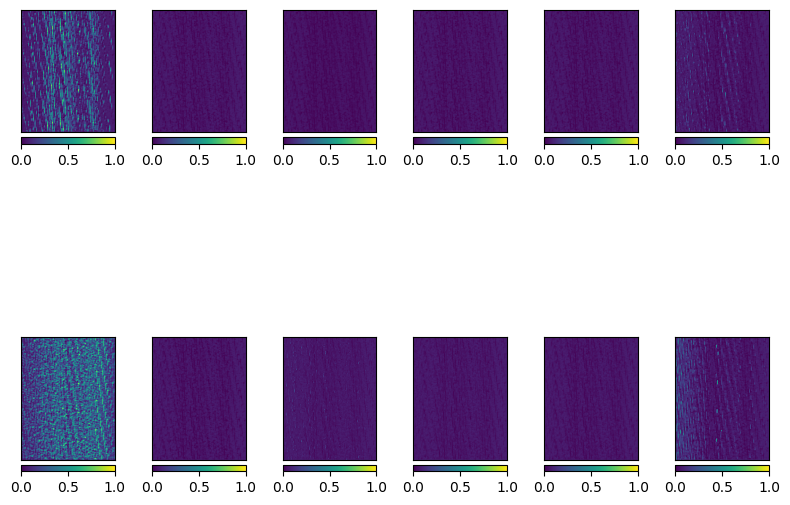

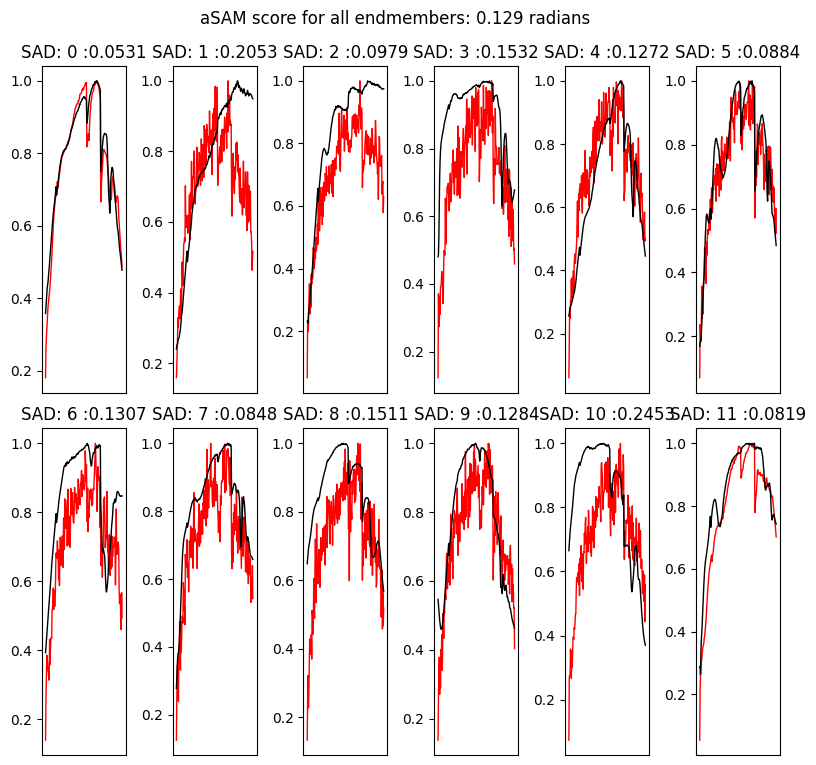

Run number: 24


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 17:14:57.110418: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_23/encoder_23/batch_normalization_47/beta/Assign' id:11596 op device:{requested: '', assigned: ''} def:{{{node autoencoder_23/encoder_23/batch_normalization_47/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_23/encoder_23/batch_normalization_47/beta, autoencoder_23/encoder_23/batch_normalization_47/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will 

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 17:18:03.661168: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_23/encoder_23/abundances/Softmax' id:11657 op device:{requested: '', assigned: ''} def:{{{node autoencoder_23/encoder_23/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_23/encoder_23/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 17:18:04.863570: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not m

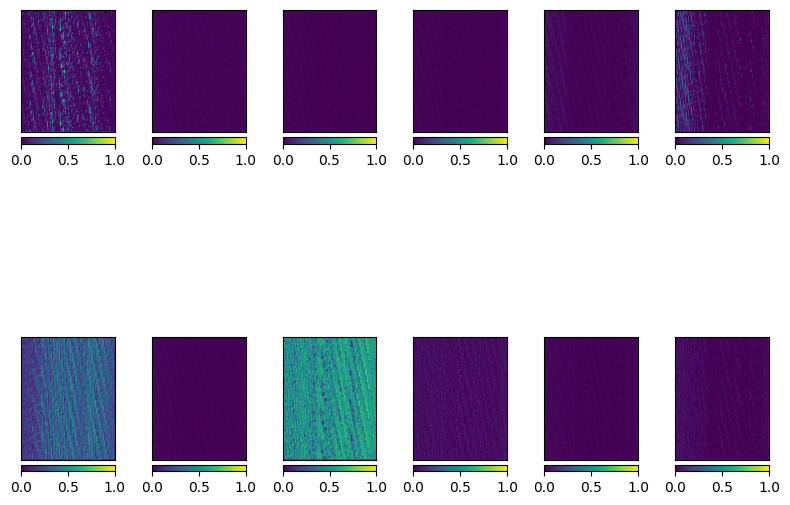

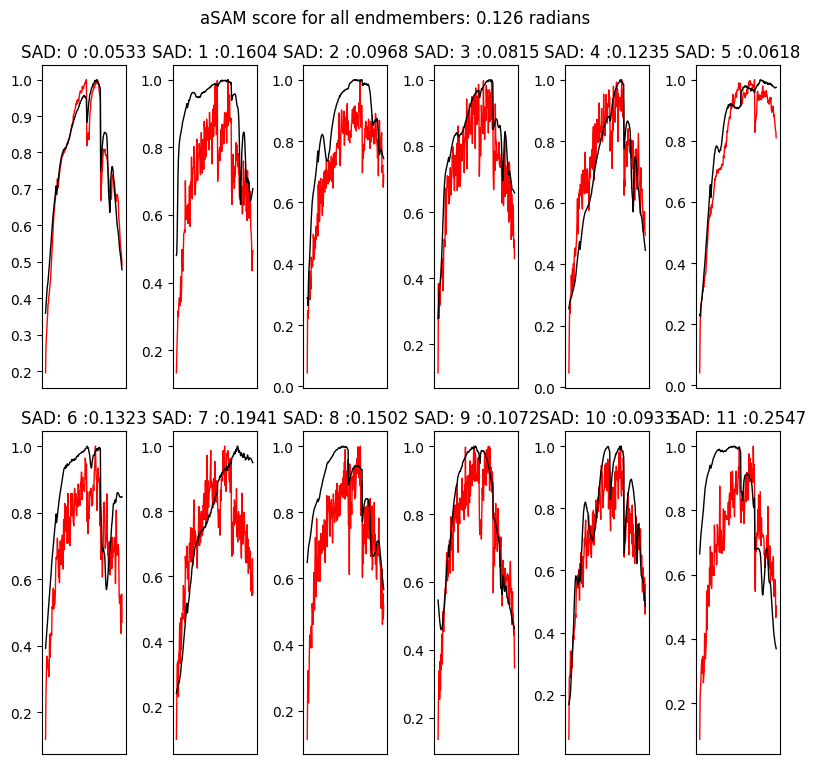

Run number: 25


/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-01-26 17:18:09.097339: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_24/encoder_24/batch_normalization_48/beta/Assign' id:12011 op device:{requested: '', assigned: ''} def:{{{node autoencoder_24/encoder_24/batch_normalization_48/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](autoencoder_24/encoder_24/batch_normalization_48/beta, autoencoder_24/encoder_24/batch_normalization_48/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will 

********************************************************************************************************************************************************************************************************************************************************************************************************************************

/home/ids/castaneda-23/anaconda3/envs/CNNAEU/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-26 17:21:07.043523: W tensorflow/c/c_api.cc:305] Operation '{name:'autoencoder_24/encoder_24/abundances/Softmax' id:12155 op device:{requested: '', assigned: ''} def:{{{node autoencoder_24/encoder_24/abundances/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](autoencoder_24/encoder_24/abundances/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-26 17:21:08.296480: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not m

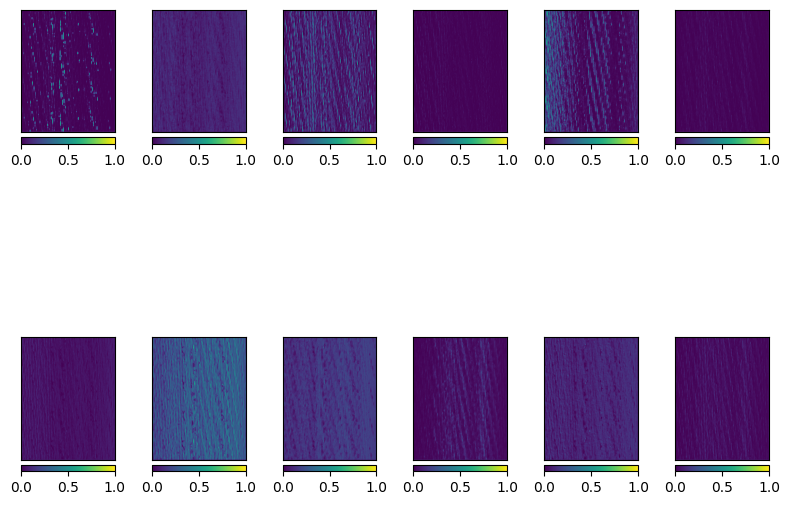

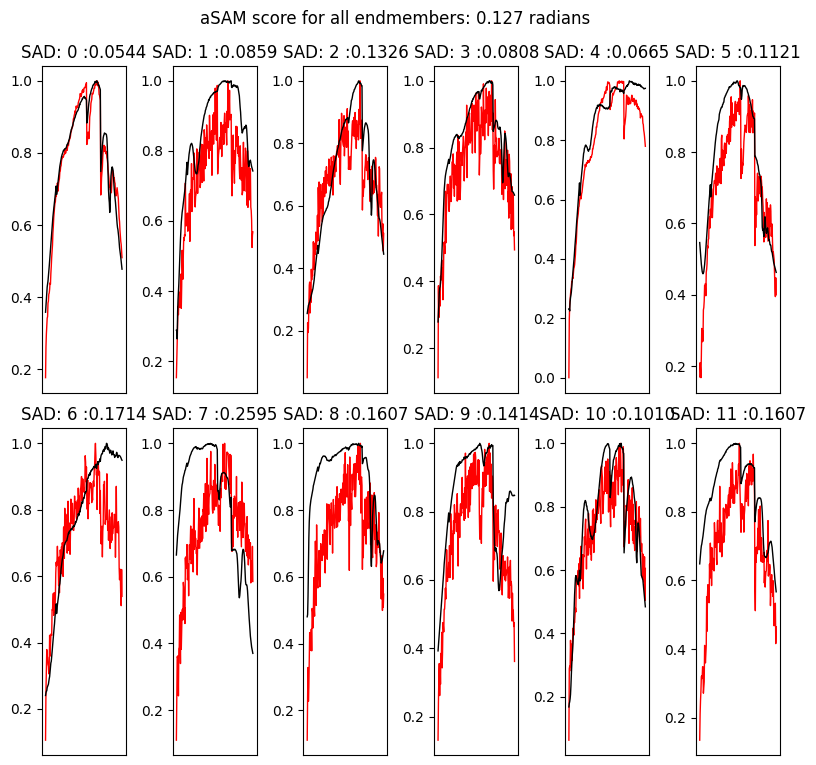

In [13]:
num_runs = 25
results_folder = './Results'
method_name = 'CNNAEU'

plot_every_n = 0 #Plot endmembers and abundance maps every x epochs. Set to 0 when running experiments. 
for dataset in ['Cuprite_fixed']:
    save_folder = results_folder+'/'+method_name+'/'+dataset
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    dataset_name = 'synthetic'

    data,GT = load_HSI(
        "./Datasets/" + datasetnames[dataset] + ".mat"
    )
    
    GT = GT
    
    for i in range(num_runs):
        print('Run number: '+str(i+1))
        save_name = dataset_name+'_run'+str(i)+'.mat'
        save_path = save_folder+'/'+save_name
        patches = training_input_fn(data, patch_size, num_patches, batch_size)
        params = {'e_filters': 48, 'e_size': 3, 'd_filters': n_bands, 'd_size': 13, 'activation': activation,
              'num_endmembers': num_endmembers, 'scale': scale, 'regularizer': regularizer,
              'initializer': initializer, 'patch_size': patch_size,
              'batch_size': batch_size, 'num_patches': num_patches, 'data': data, 'epochs': epochs}
        autoencoder = Autoencoder(params)

        autoencoder.compile(opt, loss=SAD)
        autoencoder.train(callback=PlotWhileTraining(plot_every_n, data, GT), patches=patches)
        endmembers = autoencoder.getEndmembers()
        abundances = autoencoder.getAbundances(data)
        plotAbundancesSimple(abundances)
        plotEndmembersAndGT(endmembers,GT)
        autoencoder.saveResults(save_path+'_run' + str(i+1) + '.mat')
        del autoencoder